<a href="https://colab.research.google.com/github/a-elgohary/colab-notes/blob/main/algorithmic_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#About

This project is for educational purposes only and should not be considered financial advice.


It aims to experiment with the application of machine learning techniques for stock price prediction. By utilizing the Alpha Vantage API to obtain historical stock data, we will explore data preprocessing, feature engineering, model selection, training, and evaluation processes. The goal is to provide a hands-on example of how machine learning can be applied to financial data analysis.


Please note that any trading decisions made based on the results of this project are solely at your own risk.

# Import packages

In [ ]:
!pip install mplfinance pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.0 MB/s eta 0:00:00
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=5d3d9350d256bf2272fe52ab9137098c79fc2d91f852f091b02643174df58e4a
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Fetch
import requests

# Data manipulation
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # Remove column display limit
import pandas_ta as ta
from collections import deque

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid') # Set Seaborn style
import mplfinance as mpf

# ETL

## API setup and configuration

### Alpha Vantage

[Alpha Vantage API Documentation](https://www.alphavantage.co/documentation/#)

In [ ]:
# Load the API key
from google.colab import userdata

alpha_key = userdata.get('alphavantage_key')

#### Search Endpoint

[Documentation](https://www.alphavantage.co/documentation/#symbolsearch)  

The Search Endpoint returns the best-matching symbols and market information based on keywords of your choice. The search results also contain match scores that provide you with the full flexibility to develop your own search and filtering logic.  

In [ ]:
# Function to search for symbols based on a keyword
def av_search(keyword):
    """
    Search for stock symbols based on a given keyword using the Alpha Vantage API.

    Parameters:
    - keyword (str): The keyword to search for.

    Returns:
    - df_results (pandas.DataFrame): A DataFrame containing the best matches for the given keyword.
    """
    # Base URL for the Alpha Vantage SYMBOL_SEARCH function
    base_url = "https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={keyword}&apikey={apikey}"

    # API key for authentication
    api_key = alpha_key

    # Construct the full URL with the keyword and API key
    url = base_url.format(keyword=keyword, apikey=api_key)

    # Send HTTP GET request to fetch data
    response = requests.get(url)

    # Check for successful response (status code 200)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: HTTP {response.status_code}")

    # Parse the response as JSON
    response_json = response.json()

    # Extract the 'bestMatches' section to create a DataFrame
    best_matches = response_json.get('bestMatches', [])
    df_results = pd.DataFrame(best_matches)

    return df_results

#### Time Series Daily

[Documentation](https://www.alphavantage.co/documentation/#daily)  

This API returns raw (as-traded) daily time series (date, daily open, daily high, daily low, daily close, daily volume) of the global equity specified, covering 20+ years of historical data. The OHLCV data is sometimes called "candles" in finance literature.

In [ ]:
# Function to fetch daily stock data
def av_daily(symbol, output_size):
    """
    Fetch daily stock data from Alpha Vantage based on a symbol and output size.

    Parameters:
    - symbol (str): The stock symbol to fetch data for.
    - output_size (str): The amount of data to fetch. Can be 'compact' or 'full'.

    Returns:
    - ts_df (pandas.DataFrame): A DataFrame with the daily time series data.
    """
    # Base URL for the TIME_SERIES_DAILY function
    base_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize={output_size}&apikey={apikey}"

    # API key for authentication
    api_key = alpha_key

    # Construct the full URL with the specified symbol and output size
    url = base_url.format(symbol=symbol, output_size=output_size, apikey=api_key)

    # Send HTTP GET request to fetch data
    response = requests.get(url)

    # Check for successful response (status code 200)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: HTTP {response.status_code}")

    # Parse the response as JSON
    data = response.json()

    # Extract the daily time series data
    time_series = data.get("Time Series (Daily)", {})

    # Create a DataFrame from the time series data
    ts_df = pd.DataFrame.from_dict(time_series, orient='index')

    # Convert the index to datetime for easier manipulation and analysis
    ts_df.index = pd.to_datetime(ts_df.index)

    # Return the resulting DataFrame
    return ts_df

## Fetching data

Because of the daily limit with Alpha Vantage's free API key, I'll save the results to a CSV file and comment out the code that fetches the data.

In [ ]:
# Search for Microsoft ticker
ticker_search = av_search('spy')

ticker_search

,1. symbol,2. name,3. type,4. region,5. marketOpen,6. marketClose,7. timezone,8. currency,9. matchScore
0,SPY,SPDR S&P 500 ETF Trust,ETF,United States,09:30,16:00,UTC-04,USD,1.0000
1,SPY1.FRK,SSgA SPDR ETFs Europe I Public Limited Company...,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
2,SPY2.FRK,SSgA SPDR ETFs Europe I Public Limited Company...,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
3,SPY3.LON,Leverage Shares 3x Long US 500 ETP Securities,ETF,United Kingdom,08:00,16:30,UTC+01,USD,0.6667
4,SPY4.FRK,SSgA SPDR S&P 400 US Mid Cap,ETF,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
5,SPY4.LON,SSgA SPDR ETFs Europe I Public Limited Company...,ETF,United Kingdom,08:00,16:30,UTC+01,USD,0.6667
6,SPY1.DEX,SPDR® S&P 500 Low Volatility UCITS ETF,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
7,SPY2.DEX,SPDR® Dow Jones Global Real Estate UCITS ETF U...,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
8,SPY4.DEX,SSgA SPDR S&P 400 US Mid Cap,ETF,XETRA,08:00,20:00,UTC+02,EUR,0.6000
9,SPY4.PAR,SSgA SPDR S&P 400 US Mid Cap,ETF,Paris,09:00,17:30,UTC+02,EUR,0.6000


### 	SPDR S&P 500 ETF Trust
**Ticker = "SPY"**

In [ ]:
# Set the company ticker symbol to "MSFT" for Microsoft
# This variable can be changed to analyze a different company later
ticker = "SPY"
# Retrieve the ticker name
company_name = ticker_search.loc[ticker_search['1. symbol'] == ticker, '2. name'].iloc[0]

company_name

'SPDR S&P 500 ETF Trust'

In [ ]:
# Fetch 'ticker' Data from Alpha Vantage API
df = av_daily(ticker, 'full')

print(df.isnull().sum())
df.head()

1. open      0
2. high      0
3. low       0
4. close     0
5. volume    0
dtype: int64


,1. open,2. high,3. low,4. close,5. volume
2024-08-06,519.5800,529.7400,517.8900,522.0300,84414996
2024-08-05,511.6400,523.5800,510.2700,517.3800,146267391
2024-08-02,535.7500,536.9900,528.6000,532.9000,82789070
2024-08-01,552.5700,554.8688,539.4300,543.0100,76428732
2024-07-31,548.9800,553.5000,547.5799,550.8100,65663388


In [ ]:
def clean_data(df):
    """
    Clean the DataFrame by:
     1. renaming columns
     2. Set intraday values dtype as float.
     3. Set volume dtype as int.
     4. Set the index to Datetime
     5. Sort the index in acsending order

    Parameters:
    - df (pandas.DataFrame): DataFrame containing intraday stock data.

    Returns:
    - df (pandas.DataFrame): Clean DataFrame.
    """

    # Remove the first 3 characters in the columns name
    df.columns = [col[3:] for col in df.columns]

    # Set the prices as float
    for col in df.columns[:4]:
        df[col] = df[col].astype(float)

    # Set the volume as int
    df['volume'] = df['volume'].astype(int)

    # Set index as DateTime
    df.index = pd.to_datetime(df.index)
    # Sort the data
    df.sort_index(ascending=True, inplace=True)

    return df

In [ ]:
df = clean_data(df)

print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6230 entries, 1999-11-01 to 2024-08-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6230 non-null   float64
 1   high    6230 non-null   float64
 2   low     6230 non-null   float64
 3   close   6230 non-null   float64
 4   volume  6230 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 292.0 KB
None


,open,high,low,close,volume
2024-07-31,548.98,553.5000,547.5799,550.81,65663388
2024-08-01,552.57,554.8688,539.4300,543.01,76428732
2024-08-02,535.75,536.9900,528.6000,532.90,82789070
2024-08-05,511.64,523.5800,510.2700,517.38,146267391
2024-08-06,519.58,529.7400,517.8900,522.03,84414996


# Calculate features and technical indicators

## Next Day Trend - Target

`next_day_trend` is a binary value (0 or 1) that indicates whether the closing price of the next day is higher than the closing price of the current day.

- 1: The next day's closing price is higher.
- 0: The next day's closing price is lower or equal.

We will use this variable as our target for predicting the stock's price movement from one day to the next.

In [ ]:
def add_future_close(df, n):
    """
    Add next_day_close column to the DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing intraday stock data.
    - n (int): The number of days to look ahead for the future close.

    Returns:
    - df (pandas.DataFrame): The same DataFrame with added 'target_close' column.
    """

    df[f'future_close_{n}'] = df['close'].shift(-n)
    df.dropna(inplace=True)


    return df


In [ ]:
def add_future_trend(df, n):
    """
    Add next_day_trend column to the DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing intraday stock data.
    - n (int): The number of days to look ahead for the future trend.

    Returns:
    - df (pandas.DataFrame): The same DataFrame with added 'target_trend' column.
    """

    df[f'future_trend_{n}'] = (df['close'].shift(-n) > df['close']).astype(int)
    df.dropna(inplace=True)

    return df

In [ ]:
# Create the 'next_day_close' and 'next_day_trend' columns
df = add_future_close(df, 10)
df = add_future_trend(df, 10)

df[['close', 'future_close_10', 'future_trend_10']].tail(20)

,close,future_close_10,future_trend_10
2024-06-25,544.83,561.32,1
2024-06-26,545.51,556.48,1
2024-06-27,546.37,559.99,1
2024-06-28,544.22,561.53,1
2024-07-01,545.34,564.86,1
2024-07-02,549.01,556.94,1
2024-07-03,551.46,552.66,1
2024-07-05,554.64,548.99,0
2024-07-08,555.28,554.65,0
2024-07-09,555.82,553.78,0


In [ ]:
# Create Signals DataFrame
df_signals = df[['close']].copy()

# Add next_day_trend column
df_signals = add_future_trend(df_signals, 10)

df_signals.tail()

,close,future_trend_10
2024-07-17,556.94,0
2024-07-18,552.66,0
2024-07-19,548.99,0
2024-07-22,554.65,0
2024-07-23,553.78,0


##  Intraday Price Variations

In [ ]:
def add_intraday_variations(df):
    """
    Add 'intraday_range' and 'intraday_change' columns to the DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing intraday stock data.

    Returns:
    - df (pandas.DataFrame): The same DataFrame with added variations columns.
    """
    # Calculate range
    df['intraday_range'] = df['high'] - df['low']

    # Calculate change
    df['intraday_change'] =  df['close'] - df['open']

    return df

In [ ]:
df = add_intraday_variations(df)

df[['intraday_range', 'intraday_change']].tail()

,intraday_range,intraday_change
2024-07-17,3.90,-1.86
2024-07-18,9.09,-5.85
2024-07-19,6.17,-3.43
2024-07-22,4.25,1.65
2024-07-23,3.46,-0.76


In [ ]:
df[['intraday_range', 'intraday_change']].describe()

,intraday_range,intraday_change
count,6220.000000,6220.000000
mean,2.505019,0.016939
std,2.216550,1.978871
min,0.300000,-14.080000
25%,1.170000,-0.720000
50%,1.780000,0.090000
75%,2.939850,0.820000
max,22.960000,17.280000


## Momentum Indicators

### Rate of Change (ROC)

In [ ]:
help(ta.roc)

Help on function roc in module pandas_ta.momentum.roc:

roc(close, length=None, scalar=None, talib=None, offset=None, **kwargs)
    Rate of Change (ROC)
    
    Rate of Change is an indicator is also referred to as Momentum (yeah, confusingly).
    It is a pure momentum oscillator that measures the percent change in price with the
    previous price 'n' (or length) periods ago.
    
    Sources:
        https://www.tradingview.com/wiki/Rate_of_Change_(ROC)
    
    Calculation:
        Default Inputs:
            length=1
        MOM = Momentum
        ROC = 100 * MOM(close, length) / close.shift(length)
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 1
        scalar (float): How much to magnify. Default: 100
        talib (bool): If TA Lib is installed and talib is True, Returns the TA Lib
            version. Default: True
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        fillna 

In [ ]:
def add_roc(df, n):
    """
    Calculate Rate of Change (ROC) and add it to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing intraday stock data.
    n (int): The look-back period for calculation.

    Returns:
    pd.DataFrame: DataFrame with added 'roc_n' column
    """
    df[f'roc_{n}'] = ta.roc(close=df['close'], length=n)
    return df

In [ ]:
def add_roc_signals(df_class, df, n):
  """
  Add ROC signals columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added 'roc_class' column.
  """
  # Positive ROC
  df_class[f'roc_{n}_pos'] = (df[f'roc_{n}'] > 0).astype(int)
  # Negative ROC
  df_class[f'roc_{n}_neg'] = (df[f'roc_{n}'] < 0).astype(int)
  # Trend
  df_class[f'roc_{n}_pos_trend'] = (
      (df[f'roc_{n}'] > (df[f'roc_{n}']).shift(1))).astype(int)
  df_class[f'roc_{n}_neg_trend'] = (
      (df[f'roc_{n}'] < (df[f'roc_{n}']).shift(1))).astype(int)

  return df_class

In [ ]:
df = add_roc(df, 1)

df_signals = add_roc_signals(df_signals, df, 1)

df[['close', 'roc_1']].tail(), df_signals.tail()

(             close     roc_1
 2024-07-17  556.94 -1.402117
 2024-07-18  552.66 -0.768485
 2024-07-19  548.99 -0.664061
 2024-07-22  554.65  1.030984
 2024-07-23  553.78 -0.156856,
              close  future_trend_10  roc_1_pos  roc_1_neg  roc_1_pos_trend  \
 2024-07-17  556.94                0          0          1                0   
 2024-07-18  552.66                0          0          1                1   
 2024-07-19  548.99                0          0          1                1   
 2024-07-22  554.65                0          1          0                1   
 2024-07-23  553.78                0          0          1                0   
 
             roc_1_neg_trend  
 2024-07-17                1  
 2024-07-18                0  
 2024-07-19                0  
 2024-07-22                0  
 2024-07-23                1  )

### The Relative Strength Index (RSI)

In [ ]:
help(ta.rsi)

Help on function rsi in module pandas_ta.momentum.rsi:

rsi(close, length=None, scalar=None, talib=None, drift=None, offset=None, **kwargs)
    Relative Strength Index (RSI)
    
    The Relative Strength Index is popular momentum oscillator used to measure the
    velocity as well as the magnitude of directional price movements.
    
    Sources:
        https://www.tradingview.com/wiki/Relative_Strength_Index_(RSI)
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        ABS = Absolute Value
        RMA = Rolling Moving Average
    
        diff = close.diff(drift)
        positive = diff if diff > 0 else 0
        negative = diff if diff < 0 else 0
    
        pos_avg = RMA(positive, length)
        neg_avg = ABS(RMA(negative, length))
    
        RSI = scalar * pos_avg / (pos_avg + neg_avg)
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 14
        scalar (float): How much to magnify.

In [ ]:
def add_rsi(df, n):
    """
    Calculate the Relative Strength Index (RSI) and add it to the DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing intraday stock data.
    Returns:
    - df (pandas.DataFrame): The same DataFrame with an added 'rsi_{n}' column.
    """
    df[f'rsi_{n}'] = ta.rsi(close=df['close'], length=n)
    return df


In [ ]:
df = add_rsi(df, 7)
df[['close', 'rsi_7']].tail()

,close,rsi_7
2024-07-17,556.94,52.943387
2024-07-18,552.66,43.884099
2024-07-19,548.99,37.470006
2024-07-22,554.65,50.490174
2024-07-23,553.78,48.672720


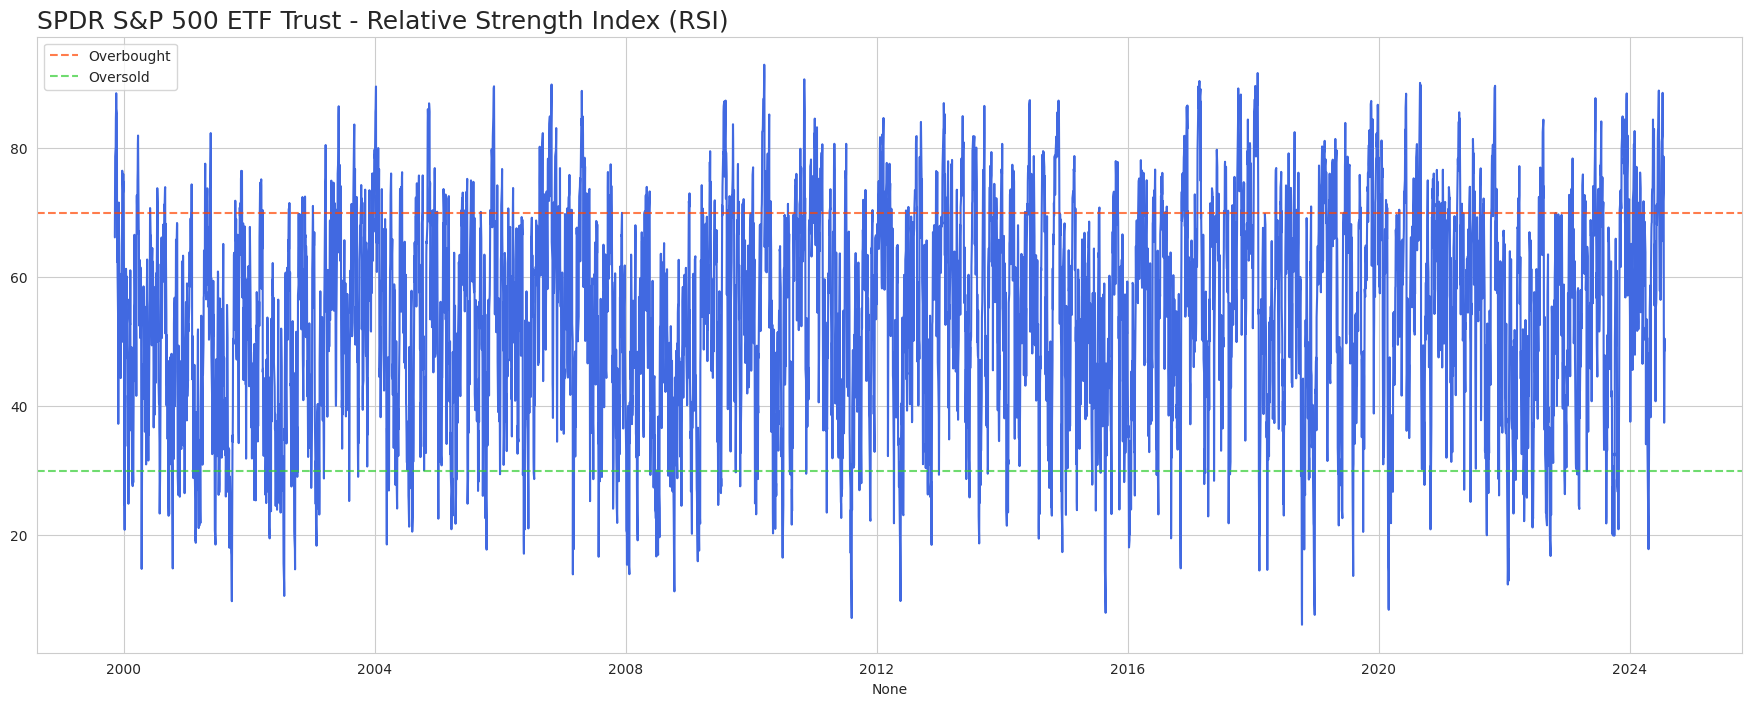

In [ ]:
# Set figure size
plt.figure(figsize=(22, 8))

# Plot Relative Strength Index
sns.lineplot(data=df, x=df.index, y=df['rsi_7'], color='royalblue')

# Set constant lines on the 70, 30 RSI
plt.axhline(70, color='orangered', linestyle='--', label='Overbought', alpha=0.7)
plt.axhline(30, color='limegreen', linestyle='--', label='Oversold', alpha=0.7)

# Set title and legend
plt.legend(loc='upper left')
plt.title(f'{company_name} - Relative Strength Index (RSI)',
          loc='left',
          fontsize=18
          )

# Remove Y label
plt.ylabel('')

plt.show();

**Interpreting RSI:**
- Above 70 often indicates an overbought condition, suggesting a potential reversal or correction.
- Below 30 indicates an oversold condition, possibly signaling a rebound.  

In [ ]:
def add_rsi_signals(df_class, df, n):
  """
  Add RSI Signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added rsi signal columns.
  """
  # Calculate Overbought conditions
  df_class[f'rsi_{n}_ob'] = (df[f'rsi_{n}'] >= 70).astype(int)
  # Calculate Oversold conditions
  df_class[f'rsi_{n}_os'] = (df[f'rsi_{n}'] <= 30).astype(int)

  return df_class

In [ ]:
df_signals = add_rsi_signals(df_signals, df, 7)

df[['close', 'rsi_7']].tail(), df_signals.iloc[:, -2:].tail()

(             close      rsi_7
 2024-07-17  556.94  52.943387
 2024-07-18  552.66  43.884099
 2024-07-19  548.99  37.470006
 2024-07-22  554.65  50.490174
 2024-07-23  553.78  48.672720,
             rsi_7_ob  rsi_7_os
 2024-07-17         0         0
 2024-07-18         0         0
 2024-07-19         0         0
 2024-07-22         0         0
 2024-07-23         0         0)

### Moving Average Convergence Divergence (MACD)

In [ ]:
help(ta.macd)

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, talib=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)
    
    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram. The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.
    
    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
        AS Mode: https://tr.tradingview.com/script/YFlKXHnP/
    
    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal
    
        if asmode:
            MACD = MACD - Signal
            Signal = EMA(MACD, signal)
          

In [ ]:
# Define the Moving Average Convergence Divergence (MACD) function
def add_macd(df, fast, slow, signal):
    """
    Calculate the Moving Average Convergence Divergence (MACD) and add it to the DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing intraday stock data.
    - fast (int): Fast EMA period.
    - slow (int): Slow EMA period.
    - signal (int): Signal EMA period.

    Returns:
    - df (pandas.DataFrame): The same DataFrame with additional MACD columns.
    """
    # Sort the data index to ensure consistency
    df.sort_index(ascending=True, inplace=True)

    # Calculate the MACD with default parameters
    macd = df.ta.macd(close=df['close'], fast=fast, slow=slow, signal=signal)
    df[macd.columns] = macd[macd.columns]

    return df

In [ ]:
# Calculate the MACD
df = add_macd(df, 5, 20, 9)

df.iloc[:, -3:].tail()

,MACD_5_20_9,MACDh_5_20_9,MACDs_5_20_9
2024-07-17,7.270557,-0.489551,7.760108
2024-07-18,4.945330,-2.251823,7.197153
2024-07-19,2.512007,-3.748116,6.260124
2024-07-22,2.312162,-3.158369,5.470531
2024-07-23,1.911075,-2.847565,4.758640


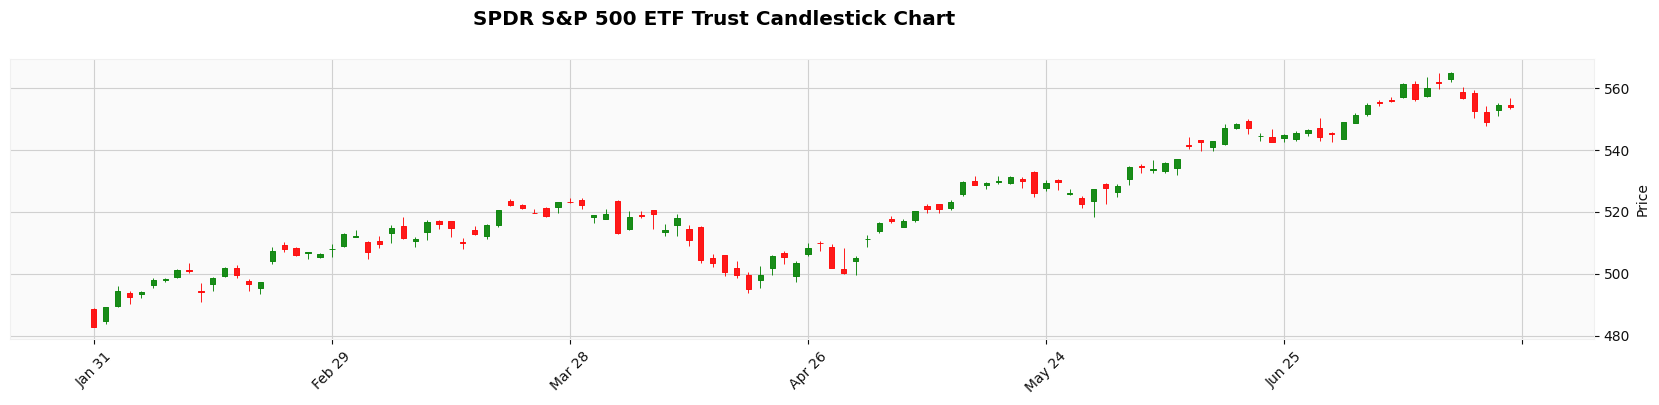

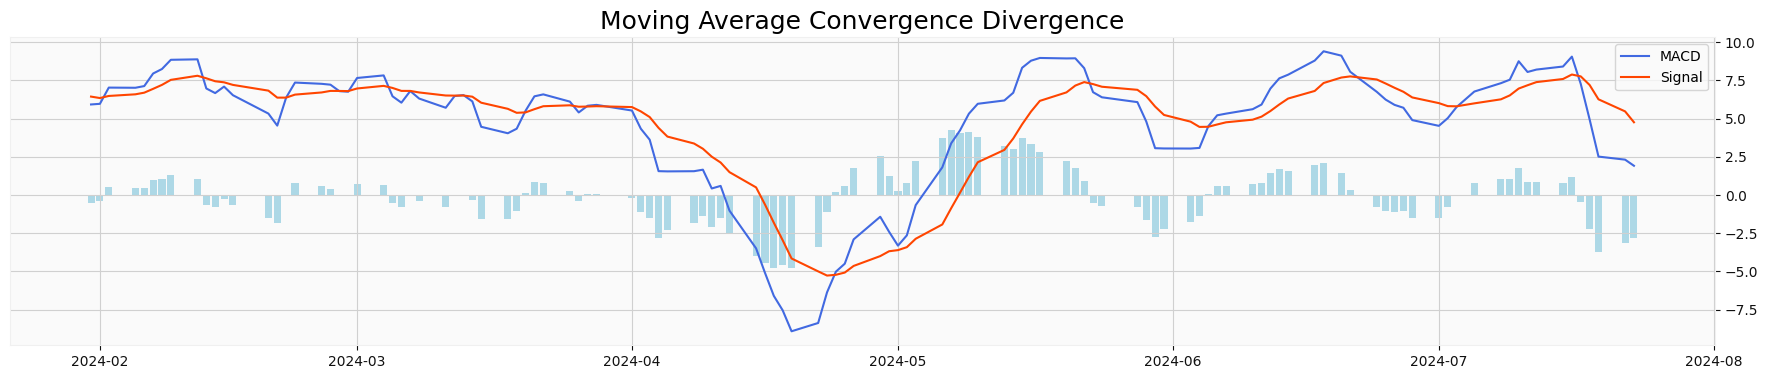

In [ ]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Create a custom plot style for mplfinance
mc = mpf.make_marketcolors(
    up='green', down='red', edge='inherit', wick='inherit', volume='in'
)

s = mpf.make_mpf_style(
    base_mpf_style='yahoo', marketcolors=mc, y_on_right=True, gridstyle='-'
)

# Plot Candlestick Chart
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    title= f'{company_name} Candlestick Chart',
    figsize=(22, 4)
)

# Set figure size
plt.figure(figsize=(22, 4))

# Create a new subplot
ax = plt.gca()

# Plot MACD, MACD Signal, and MACD histogram
ax.plot(plot_data.index, plot_data['MACD_5_20_9'], color='royalblue', label='MACD')
ax.plot(plot_data.index, plot_data['MACDs_5_20_9'], color='orangered', label='Signal')
ax.bar(plot_data.index, plot_data['MACDh_5_20_9'], color='lightblue')

# Show Legend
ax.legend(loc='upper right')

# Set title
ax.set_title('Moving Average Convergence Divergence', loc='center', fontsize=18)

# Move Y axis ticks to the right
ax.yaxis.tick_right()
# Set label position to the right
ax.yaxis.set_label_position("right")

plt.show();

**Interpreting MACD:**

- **Crossovers between MACD and Signal Line**:
  - When the MACD line crosses above the signal line, it may indicate a buy signal, suggesting a potential upward trend.
  - Conversely, when the MACD line crosses below the signal line, it may indicate a sell signal, suggesting a potential downward trend.

- **Position Relative to Zero Line**:
  - If the MACD line is above zero, it suggests a bullish market condition. This indicates that the shorter EMA is higher than the longer EMA, reflecting positive momentum.
  - If the MACD line is below zero, it suggests a bearish market condition, indicating negative momentum.

- **Histogram Analysis**:
  - The histogram represents the difference between the MACD line and the signal line. If the histogram is increasing (positive bars getting taller or negative bars getting shorter), it suggests strengthening momentum in the direction of the trend.
  - If the histogram is decreasing (positive bars getting shorter or negative bars getting taller), it suggests weakening momentum and could signal a potential trend reversal.

- **Magnitude of the Histogram**:
  - A larger magnitude of the histogram (either positive or negative) suggests higher volatility and stronger price movements.
  - Smaller magnitudes indicate lower volatility and more stable price movements.

In [ ]:
def add_macd_signals(df_class, df, fast, slow, signal):
  """
  Add MACD Signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - fast (int): Fast EMA period.
  - slow (int): Slow EMA period.
  - signal (int): Signal EMA period.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added macd signal columns.
  """
  # macd columns
  macd = f'MACD_{fast}_{slow}_{signal}'
  macd_h = f'MACDh_{fast}_{slow}_{signal}'
  macd_s = f'MACDs_{fast}_{slow}_{signal}'

  # Buy signal
  df_class[f'{macd}_buy'] = (
      (df[macd] > df[macd_s])
      & (df[macd] < df[macd_s]).shift(1)
      ).astype(int)
  # Sell signal
  df_class[f'{macd}_sell'] = (
      (df[macd] < df[macd_s])
      & (df[macd] > df[macd_s]).shift(1)
      ).astype(int)
  # Bullish Market signal
  df_class['macd_bull_market'] = (df[macd] > 0).astype(int)
  # Bearish Market signal
  df_class['macd_bear_market'] = (df[macd] < 0).astype(int)

  return df_class


In [ ]:
df_signals = add_macd_signals(df_signals, df, 5, 20, 9)

df_signals.iloc[:, -4:].tail()

,MACD_5_20_9_buy,MACD_5_20_9_sell,macd_bull_market,macd_bear_market
2024-07-17,0,1,1,0
2024-07-18,0,0,1,0
2024-07-19,0,0,1,0
2024-07-22,0,0,1,0
2024-07-23,0,0,1,0


### Stochastic Oscillator (Stoch)

In [ ]:
help(ta.stoch)

Help on function stoch in module pandas_ta.momentum.stoch:

stoch(high, low, close, k=None, d=None, smooth_k=None, mamode=None, offset=None, **kwargs)
    Stochastic (STOCH)
    
    The Stochastic Oscillator (STOCH) was developed by George Lane in the 1950's.
    He believed this indicator was a good way to measure momentum because changes in
    momentum precede changes in price.
    
    It is a range-bound oscillator with two lines moving between 0 and 100.
    The first line (%K) displays the current close in relation to the period's
    high/low range. The second line (%D) is a Simple Moving Average of the %K line.
    The most common choices are a 14 period %K and a 3 period SMA for %D.
    
    Sources:
        https://www.tradingview.com/wiki/Stochastic_(STOCH)
        https://www.sierrachart.com/index.php?page=doc/StudiesReference.php&ID=332&Name=KD_-_Slow
    
    Calculation:
        Default Inputs:
            k=14, d=3, smooth_k=3
        SMA = Simple Moving Average
     

In [ ]:
def add_stoch_ta(df, k, d, smooth_k):
    """
    Calculate the stochastic oscillator values (K and D) and add them to the DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing intraday stock data.
    - k (int): Rolling window size for %K calculation.
    - d (int): Rolling window size for %D calculation.
    - smooth_k (int): Smoothing period for %K.

    Returns:
    - df (pandas.DataFrame): The same DataFrame with added '%K' and '%D' columns.
    """
    # Calculate %K and %D
    stoch = ta.stoch(high=df['high'], low=df['low'], close=df['close'], k=k, d=d, smooth_k=smooth_k)

    # Add stoch columns to df
    df[stoch.columns] = stoch[stoch.columns]

    return df


In [ ]:
df = add_stoch_ta(df, k=5, d=3, smooth_k=3)

df.iloc[:, -2:].tail()

,STOCHk_5_3_3,STOCHd_5_3_3
2024-07-17,57.728907,63.239856
2024-07-18,41.273615,57.719846
2024-07-19,11.099049,36.700524
2024-07-22,20.157502,24.176722
2024-07-23,30.640212,20.632254


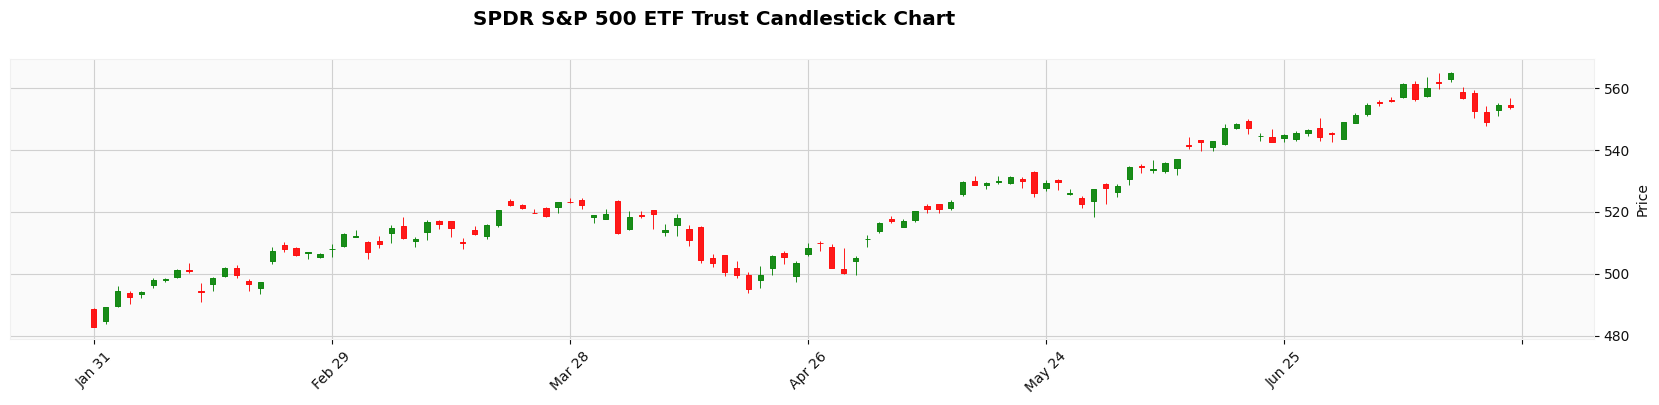

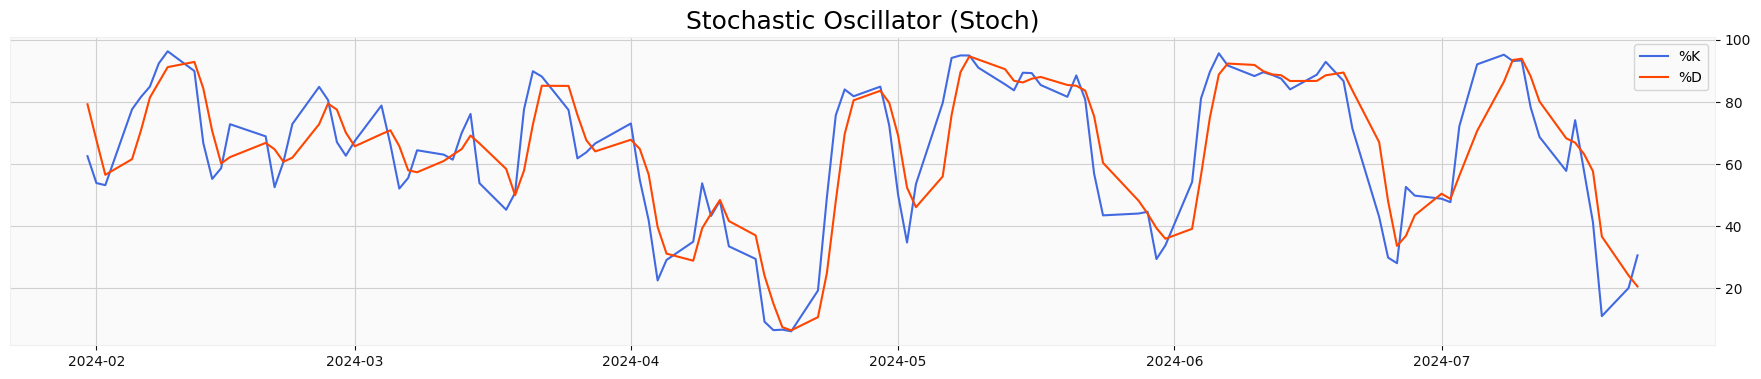

In [ ]:
 # Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    title= f'{company_name} Candlestick Chart',
    figsize=(22, 4)
)

# Set figure size
plt.figure(figsize=(22, 4))

# Create a new subplot
ax = plt.gca()

# Plot %K and %D values
ax.plot(plot_data.index, plot_data['STOCHk_5_3_3'], color='royalblue', label='%K')
ax.plot(plot_data.index, plot_data['STOCHd_5_3_3'], color='orangered', label='%D')

# Show Legend
ax.legend(loc='upper right')

# Set title
ax.set_title('Stochastic Oscillator (Stoch)', loc='center', fontsize=18)

# Move Y axis ticks to the right
ax.yaxis.tick_right()
# Set label position to the right
ax.yaxis.set_label_position("right")

plt.show();

**Interpreting Stoch:**

- Overbought and Oversold Conditions
  - Overbought: %K or %D is above 80.
  - Oversold: %K or %D is below 20.

- Stochastic Crossovers
  - Bullish Crossover: %K line crosses above the %D line.
  - Bearish Crossover: %K line crosses below the %D line.

- Centerline Crossovers
  - Crossing Above 50: Indicates increasing bullish momentum and a potential continuation of an uptrend.
  - Crossing Below 50: Indicates increasing bearish momentum and a potential continuation of a downtrend.


In [ ]:
def add_stoch_signals(df_class, df, k, d, smooth_k):
  """
  Add Stoch signals columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - k (int): Rolling window size for %K calculation.
  - d (int): Rolling window size for %D calculation.
  - smooth_k (int): Smoothing period for %K.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added stoch signal columns.
  """

  # Stoch columns
  stoch_k = f'STOCHk_{k}_{d}_{smooth_k}'
  stoch_d = f'STOCHd_{k}_{d}_{smooth_k}'

  # Overbought condition
  df_class[f'{stoch_k}_ob'] = ((df[stoch_k] >= 80) | (df[stoch_d] >= 80)).astype(int)

  # Oversold condition
  df_class[f'{stoch_k}_os'] = ((df[stoch_k] <= 20) | (df[stoch_d] <= 20)).astype(int)

  # Bullish Crossover
  df_class['stoch_bull_cross'] = (
      (df[stoch_k] > df[stoch_d])
      & (df[stoch_k] < df[stoch_d]).shift(1)
      ).astype(int)

  # Bearish Crossover
  df_class['stoch_bear_cross'] = (
      (df[stoch_k] < df[stoch_d])
      & (df[stoch_k] > df[stoch_d]).shift(1)
      ).astype(int)

  # Bullish market
  df_class['stoch_bull_market'] = ((df[stoch_d] >= 50)).astype(int)
  # Bearish market
  df_class['stoch_bear_market'] = ((df[stoch_d] <= 50)).astype(int)

  return df_class




In [ ]:
df_signals = add_stoch_signals(df_signals, df, 5, 3, 3)

df_signals.iloc[:, -5:].tail()

,STOCHk_5_3_3_os,stoch_bull_cross,stoch_bear_cross,stoch_bull_market,stoch_bear_market
2024-07-17,0,0,1,1,0
2024-07-18,0,0,0,1,0
2024-07-19,1,0,0,0,1
2024-07-22,0,0,0,0,1
2024-07-23,0,1,0,0,1


### Commodity Channel Index (CCI)

In [ ]:
help(ta.cci)

Help on function cci in module pandas_ta.momentum.cci:

cci(high, low, close, length=None, c=None, talib=None, offset=None, **kwargs)
    Commodity Channel Index (CCI)
    
    Commodity Channel Index is a momentum oscillator used to primarily identify
    overbought and oversold levels relative to a mean.
    
    Sources:
        https://www.tradingview.com/wiki/Commodity_Channel_Index_(CCI)
    
    Calculation:
        Default Inputs:
            length=14, c=0.015
        SMA = Simple Moving Average
        MAD = Mean Absolute Deviation
        tp = typical_price = hlc3 = (high + low + close) / 3
        mean_tp = SMA(tp, length)
        mad_tp = MAD(tp, length)
        CCI = (tp - mean_tp) / (c * mad_tp)
    
    Args:
        high (pd.Series): Series of 'high's
        low (pd.Series): Series of 'low's
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 14
        c (float): Scaling Constant. Default: 0.015
        talib (bool): If TA Lib is

In [ ]:
def add_cci(df, n):
  """
  Calculate the Commodity Channel Index (CCI) and add it to the DataFrame.

  Parameters:
  - df (pandas.DataFrame): The DataFrame containing stock data.
  - n (int): The look-back period for calculation.

  Returns:
  - df (pandas.DataFrame): The same DataFrame with added 'cci' column.
  """
  # Calculate the CCI
  df[f'cci_{n}'] = ta.cci(high=df['high'], low=df['low'], close=df['close'], length=n)

  return df

In [ ]:
df = add_cci(df, 7)

df.iloc[:, -1:].tail()

,cci_7
2024-07-17,-59.430036
2024-07-18,-152.613618
2024-07-19,-153.337828
2024-07-22,-62.775036
2024-07-23,-34.924412


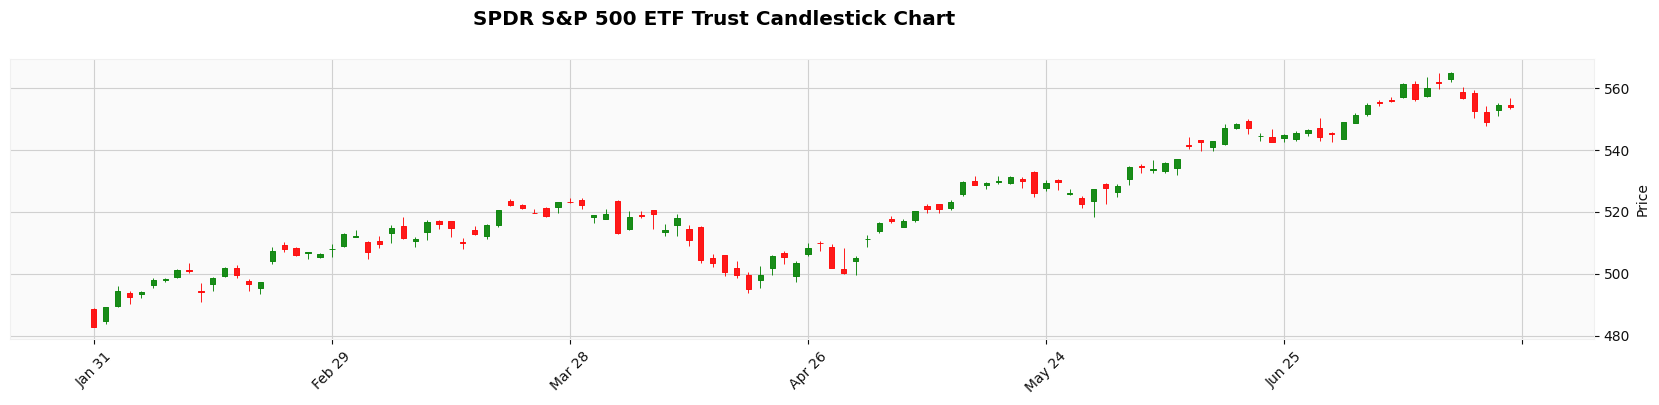

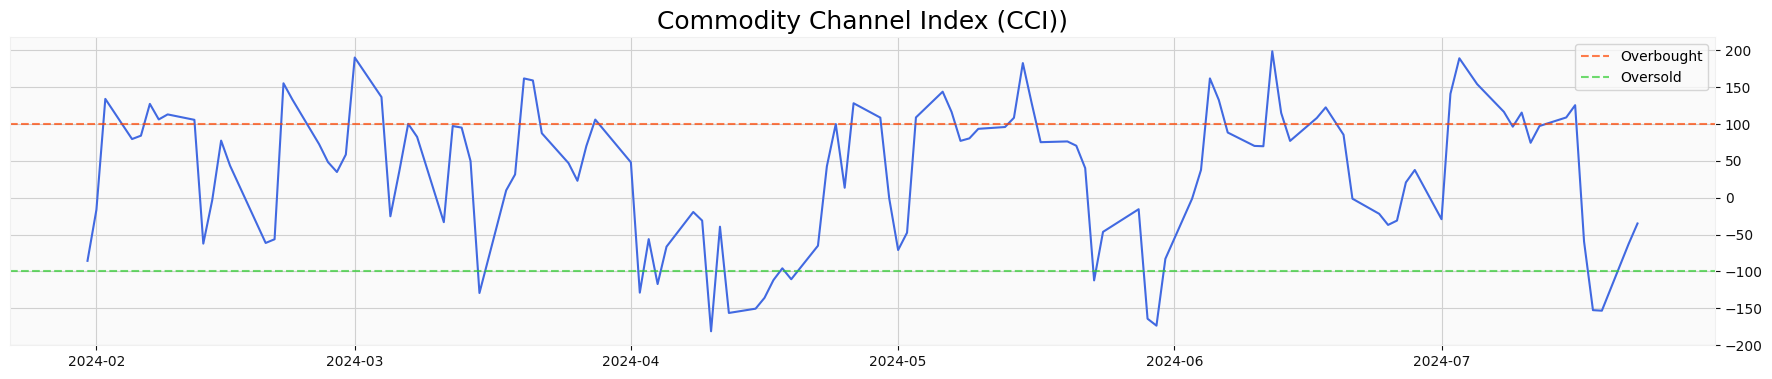

In [ ]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    title= f'{company_name} Candlestick Chart',
    figsize=(22, 4)
)

# Set figure size
plt.figure(figsize=(22, 4))

# Create a new subplot
ax = plt.gca()

# Plot Commodity Channel Index (CCI)
ax.plot(plot_data.index, plot_data['cci_7'], color='royalblue')

# Set constant lines
plt.axhline(100, color='orangered', linestyle='--', label='Overbought', alpha=0.7)
plt.axhline(-100, color='limegreen', linestyle='--', label='Oversold', alpha=0.7)


# Show Legend
ax.legend(loc='upper right')

# Set title
ax.set_title('Commodity Channel Index (CCI))', loc='center', fontsize=18)

# Move Y axis ticks to the right
ax.yaxis.tick_right()
# Set label position to the right
ax.yaxis.set_label_position("right")

plt.show();

**Interpreting Commodity Channel Index (CCI)**

- Above +100: Overbought
- Below -100: Oversold
- Crossing zero line: Potential trend change
- Divergence with price: Possible reversal signal
- Extreme readings (±200): Strong trend, potential reversal

Best Used for
- Identifying cyclical trends
- Spotting overbought/oversold conditions
- Detecting divergences


In [ ]:
def add_cci_signals(df_class, df, n):
  """
  Add CCI Signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added cci signal columns.
  """
  # CCI columns
  cci = f'cci_{n}'

  # Overbought
  df_class[f'{cci}_ob'] = (df[cci] >= 100).astype(int)
  # Oversold
  df_class[f'{cci}_os'] = (df[cci] <= -100).astype(int)
  # Extreme Readings
  df_class['cci_extreme_pos'] = (df[cci] >= 200).astype(int)
  df_class['cci_extreme_neg'] = (df[cci] <= -200).astype(int)
  # Crossing above 0
  df_class['cci_cross_0_up'] = ((df[cci] > 0) & (df[cci] < 0).shift(1)).astype(int)
  # Crossing below 0
  df_class['cci_cross_0_down'] = ((df[cci] < 0) & (df[cci] > 0).shift(1)).astype(int)

  return df_class

In [ ]:
df_signals = add_cci_signals(df_signals, df, 7)

df_signals.iloc[:, -6:].tail()

,cci_7_ob,cci_7_os,cci_extreme_pos,cci_extreme_neg,cci_cross_0_up,cci_cross_0_down
2024-07-17,0,0,0,0,0,1
2024-07-18,0,1,0,0,0,0
2024-07-19,0,1,0,0,0,0
2024-07-22,0,0,0,0,0,0
2024-07-23,0,0,0,0,0,0


### Chande Momentum Oscillator (CMO)

In [ ]:
help(ta.cmo)

Help on function cmo in module pandas_ta.momentum.cmo:

cmo(close, length=None, scalar=None, talib=None, drift=None, offset=None, **kwargs)
    Chande Momentum Oscillator (CMO)
    
    Attempts to capture the momentum of an asset with overbought at 50 and
    oversold at -50.
    
    Sources:
        https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/chande-momentum-oscillator-cmo/
        https://www.tradingview.com/script/hdrf0fXV-Variable-Index-Dynamic-Average-VIDYA/
    
    Calculation:
        Default Inputs:
            drift=1, scalar=100
    
        # Same Calculation as RSI except for this step
        CMO = scalar * (PSUM - NSUM) / (PSUM + NSUM)
    
    Args:
        close (pd.Series): Series of 'close's
        scalar (float): How much to magnify. Default: 100
        talib (bool): If TA Lib is installed and talib is True, Returns the TA Lib
            version. If TA Lib is not installed but talib is True, it runs the Python
            ve

In [ ]:
def add_cmo(df, n):
  """
  Calculate the Chande Momentum Oscillator (CMO) and add it to the DataFrame.
  Parameters:
  - df (pandas.DataFrame): The DataFrame containing stock data.
  - n (int): The look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added 'cmo' column.
  """

  # Calculate Chande Momentum Oscillator (CMO)
  df[f'cmo_{n}'] = ta.cmo(close=df['close'], length=n)

  return df

In [ ]:
df = add_cmo(df, n=7)

df.iloc[:, -2:].tail()

,cci_7,cmo_7
2024-07-17,-59.430036,5.886775
2024-07-18,-152.613618,-12.231803
2024-07-19,-153.337828,-25.059988
2024-07-22,-62.775036,0.980349
2024-07-23,-34.924412,-2.654559


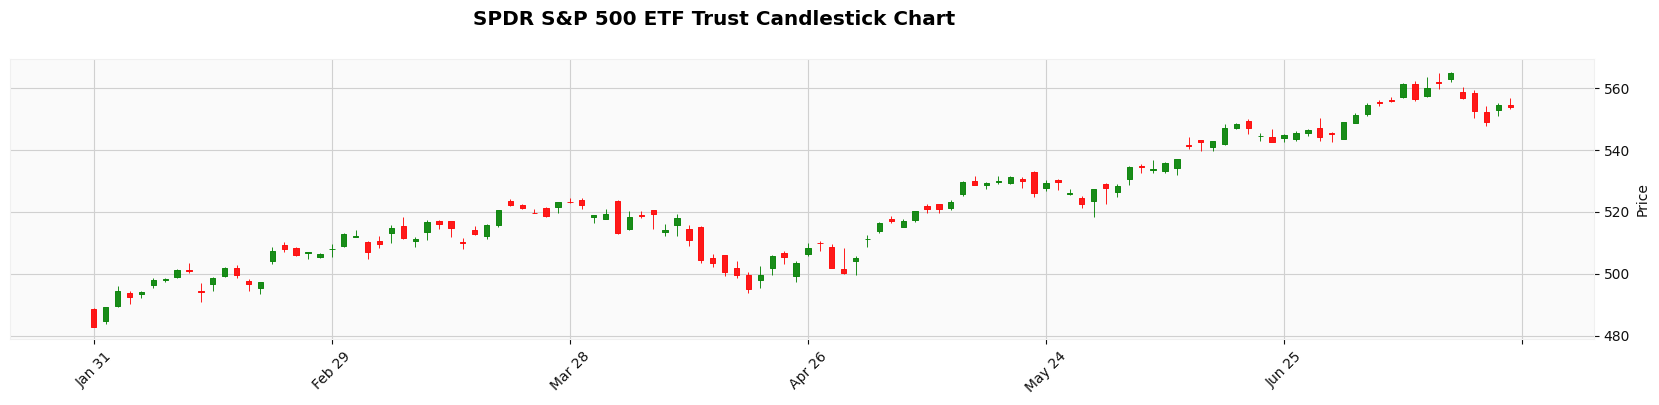

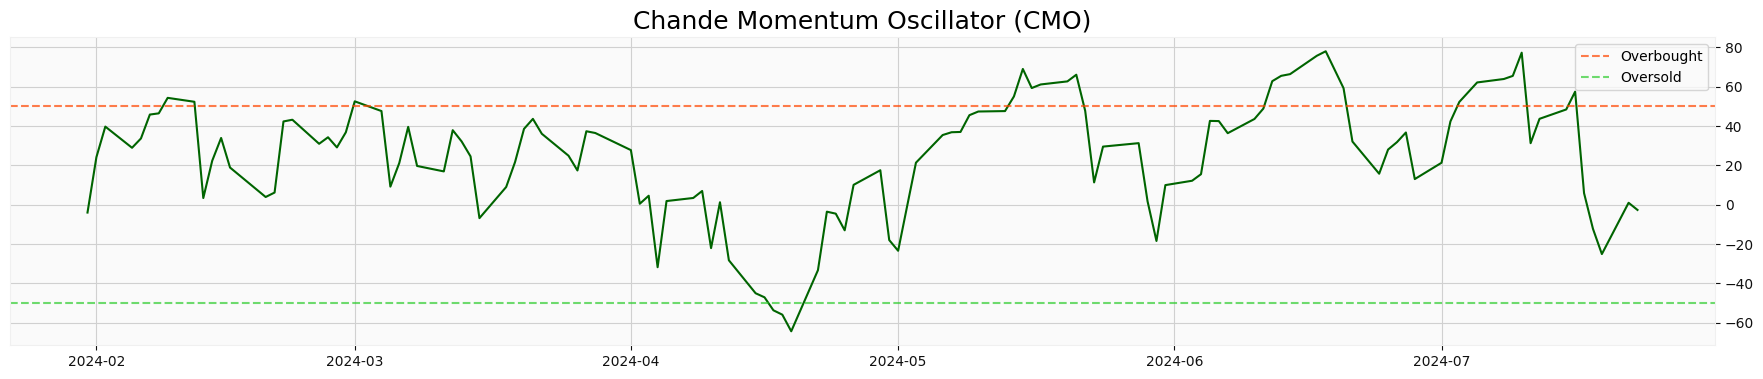

In [ ]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    title= f'{company_name} Candlestick Chart',
    figsize=(22, 4)
)

# Set figure size
plt.figure(figsize=(22, 4))

# Create a new subplot
ax = plt.gca()

# Plot Money Flow Index (MFI)
ax.plot(plot_data.index, plot_data['cmo_7'], color='darkgreen')

# Set constant lines
plt.axhline(50, color='orangered', linestyle='--', label='Overbought', alpha=0.7)
plt.axhline(-50, color='limegreen', linestyle='--', label='Oversold', alpha=0.7)


# Show Legend
ax.legend(loc='upper right')

# Set title
ax.set_title('Chande Momentum Oscillator (CMO)', loc='center', fontsize=18)

# Move Y axis ticks to the right
ax.yaxis.tick_right()
# Set label position to the right
ax.yaxis.set_label_position("right")

plt.show();

**Interpreting CMO:**
- Above +50: Overbought
- Below -50: Oversold
- Crossing zero line: Potential trend change
- Divergence with price: Possible reversal signal
- Extreme readings (±70): Strong trend, potential reversal

Best Used
- Identifying overbought/oversold conditions
- Spotting potential trend reversals
- Measuring the strength of trends


In [ ]:
def add_cmo_signals(df_class, df, n):
  """
  Add CMO Signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added cmo signal columns.
  """
  # CMO columns
  cmo = f'cmo_{n}'

  # Overbought
  df_class[f'{cmo}_ob'] = (df[cmo] >= 50).astype(int)
  # Oversold
  df_class[f'{cmo}_os'] = (df[cmo] <= -50).astype(int)
  # Extreme Readings
  df_class['cmo_extreme_pos'] = (df[cmo] >= 70).astype(int)
  df_class['cmo_extreme_neg'] = (df[cmo] <= -70).astype(int)
  # Crossing above 0
  df_class['cmo_cross_0_up'] = ((df[cmo] > 0) & (df[cmo] < 0).shift(1)).astype(int)
  # Crossing below 0
  df_class['cmo_cross_0_down'] = ((df[cmo] < 0) & (df[cmo] > 0).shift(1)).astype(int)

  return df_class

In [ ]:
df_signals = add_cmo_signals(df_signals, df, 7)

df_signals.iloc[:, -6:].tail()

,cmo_7_ob,cmo_7_os,cmo_extreme_pos,cmo_extreme_neg,cmo_cross_0_up,cmo_cross_0_down
2024-07-17,0,0,0,0,0,0
2024-07-18,0,0,0,0,0,1
2024-07-19,0,0,0,0,0,0
2024-07-22,0,0,0,0,1,0
2024-07-23,0,0,0,0,0,1


### Williams %R

In [ ]:
help(ta.willr)

Help on function willr in module pandas_ta.momentum.willr:

willr(high, low, close, length=None, talib=None, offset=None, **kwargs)
    William's Percent R (WILLR)
    
    William's Percent R is a momentum oscillator similar to the RSI that
    attempts to identify overbought and oversold conditions.
    
    Sources:
        https://www.tradingview.com/wiki/Williams_%25R_(%25R)
    
    Calculation:
        Default Inputs:
            length=20
        LL = low.rolling(length).min()
        HH = high.rolling(length).max()
    
        WILLR = 100 * ((close - LL) / (HH - LL) - 1)
    
    Args:
        high (pd.Series): Series of 'high's
        low (pd.Series): Series of 'low's
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 14
        talib (bool): If TA Lib is installed and talib is True, Returns the TA Lib
            version. Default: True
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        fil

In [ ]:
def add_willr(df, n):
  """
  Calculate the Williams %R and add it to the DataFrame.

  Parameters:
  - df (pandas.DataFrame): The DataFrame containing stock data.
  - n (int): The look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added 'willr' column.
  """

  # Calculate Williams %R
  df[f'willr_{n}'] = ta.willr(high=df['high'], low=df['low'], close=df['close'], length=n)

  return df

In [ ]:
df = add_willr(df, 7)

df.iloc[:, -1:].tail()

,willr_7
2024-07-17,-85.269710
2024-07-18,-84.860828
2024-07-19,-93.739130
2024-07-22,-60.927536
2024-07-23,-65.971014


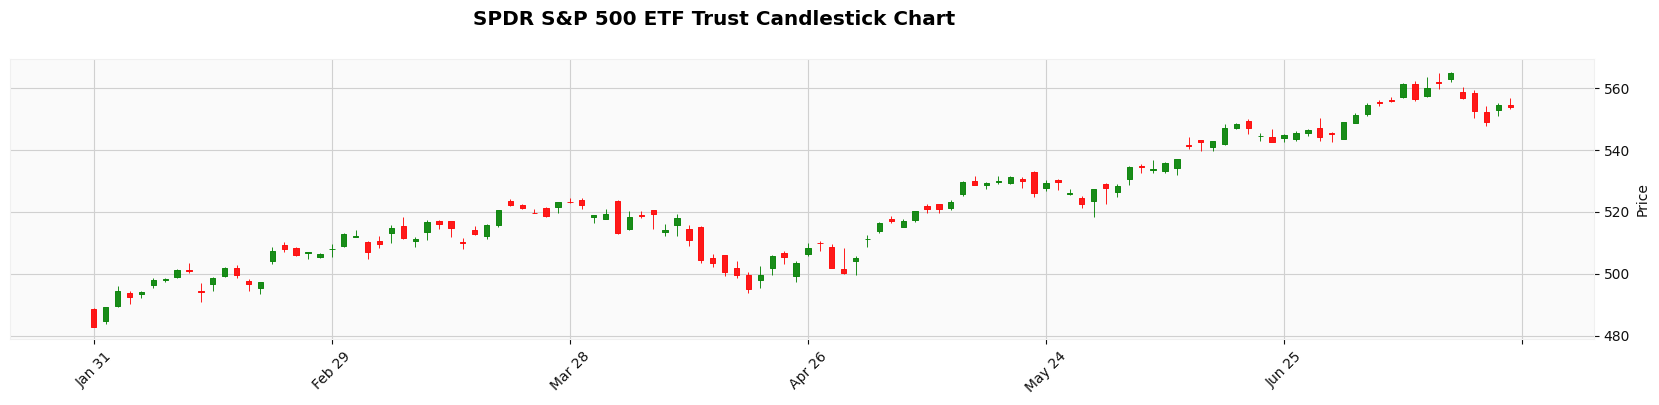

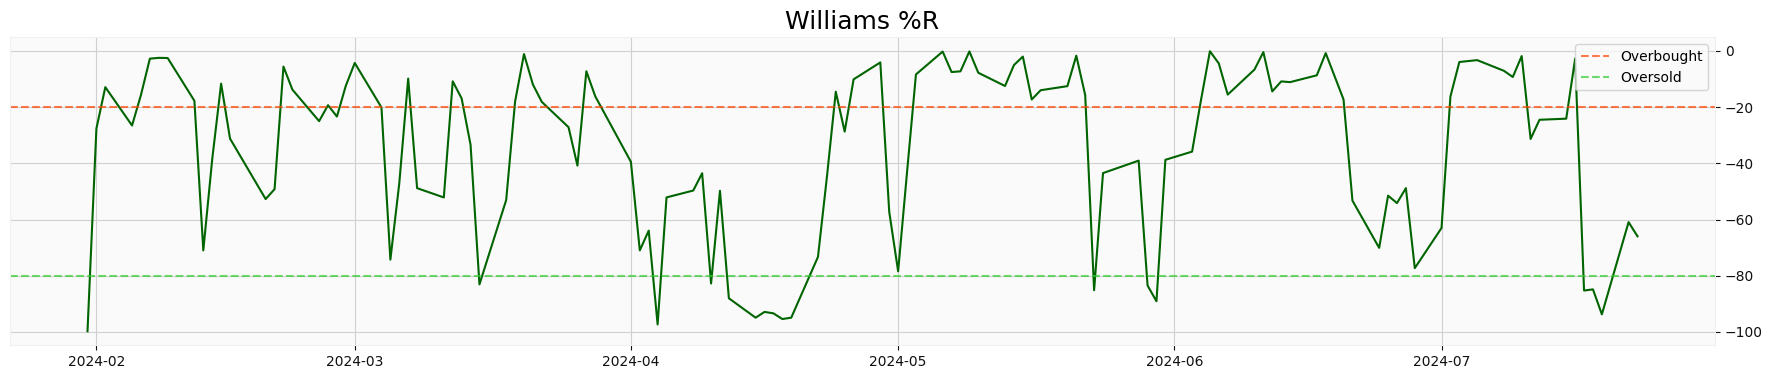

In [ ]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    title= f'{company_name} Candlestick Chart',
    figsize=(22, 4)
)

# Set figure size
plt.figure(figsize=(22, 4))

# Create a new subplot
ax = plt.gca()

# Plot Williams %R
ax.plot(plot_data.index, plot_data['willr_7'], color='darkgreen')

# Set constant lines
plt.axhline(-20, color='orangered', linestyle='--', label='Overbought', alpha=0.7)
plt.axhline(-80, color='limegreen', linestyle='--', label='Oversold', alpha=0.7)


# Show Legend
ax.legend(loc='upper right')

# Set title
ax.set_title('Williams %R', loc='center', fontsize=18)

# Move Y axis ticks to the right
ax.yaxis.tick_right()
# Set label position to the right
ax.yaxis.set_label_position("right")

plt.show();

**Interpreting Williams %R**
- 0 to -20: Overbought
- -80 to -100: Oversold
- Divergence with price: Possible reversal signal
- Crossing -50 line: Potential momentum shift

Best Used
- Identifying overbought/oversold conditions
- Spotting potential trend reversals
- Confirming other indicators


In [ ]:
def add_willr_signals(df_class, df, n):
  """
  Add Williams %R Signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added willr signal columns.
  """
  # Williams %R columns
  willr = f'willr_{n}'

  # Overbought
  df_class[f'{willr}_ob'] = (df[willr] <= -20).astype(int)
  # Oversold
  df_class[f'{willr}_os'] = (df[willr] >= -80).astype(int)
  # Crossing down -50 line
  df_class['willr_cross_50_down'] = ((df[willr] < -50) & (df[willr] > -50).shift(1)).astype(int)
  # Crossing up -50 line
  df_class['willr_cross_50_up'] = ((df[willr] > -50) & (df[willr] < -50).shift(1)).astype(int)

  return df_class

In [ ]:
df_signals = add_willr_signals(df_signals, df, 7)

df_signals.iloc[:, -4:].tail(20)

,willr_7_ob,willr_7_os,willr_cross_50_down,willr_cross_50_up
2024-06-25,1,1,0,0
2024-06-26,1,1,0,0
2024-06-27,1,1,0,1
2024-06-28,1,1,1,0
2024-07-01,1,1,0,0
2024-07-02,0,1,0,1
2024-07-03,0,1,0,0
2024-07-05,0,1,0,0
2024-07-08,0,1,0,0
2024-07-09,0,1,0,0


## Overlap Indicators

### Exponential Moving Average (EMA)

In [ ]:
help(ta.ema)

Help on function ema in module pandas_ta.overlap.ema:

ema(close, length=None, talib=None, offset=None, **kwargs)
    Exponential Moving Average (EMA)
    
    The Exponential Moving Average is more responsive moving average compared to the
    Simple Moving Average (SMA).  The weights are determined by alpha which is
    proportional to it's length.  There are several different methods of calculating
    EMA.  One method uses just the standard definition of EMA and another uses the
    SMA to generate the initial value for the rest of the calculation.
    
    Sources:
        https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:moving_averages
        https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    
    Calculation:
        Default Inputs:
            length=10, adjust=False, sma=True
        if sma:
            sma_nth = close[0:length].sum() / length
            close[:length - 1] = n

In [ ]:
def add_ema(df, n):
    """
    Calculate the Exponential Moving Average (EMA) and add it to the DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing intraday stock data.
    - n (int): The period of the EMA.

    Returns:
    - df (pandas.DataFrame): The same DataFrame with added 'ema' column.
    """
    # Calculate the EMA
    df[f'ema_{n}'] = ta.ema(close=df['close'], length=n)

    return df

In [ ]:
df = add_ema(df, n=10)

df.iloc[:, -1:].tail()

,ema_10
2024-07-17,557.252093
2024-07-18,556.417167
2024-07-19,555.066773
2024-07-22,554.990996
2024-07-23,554.770815


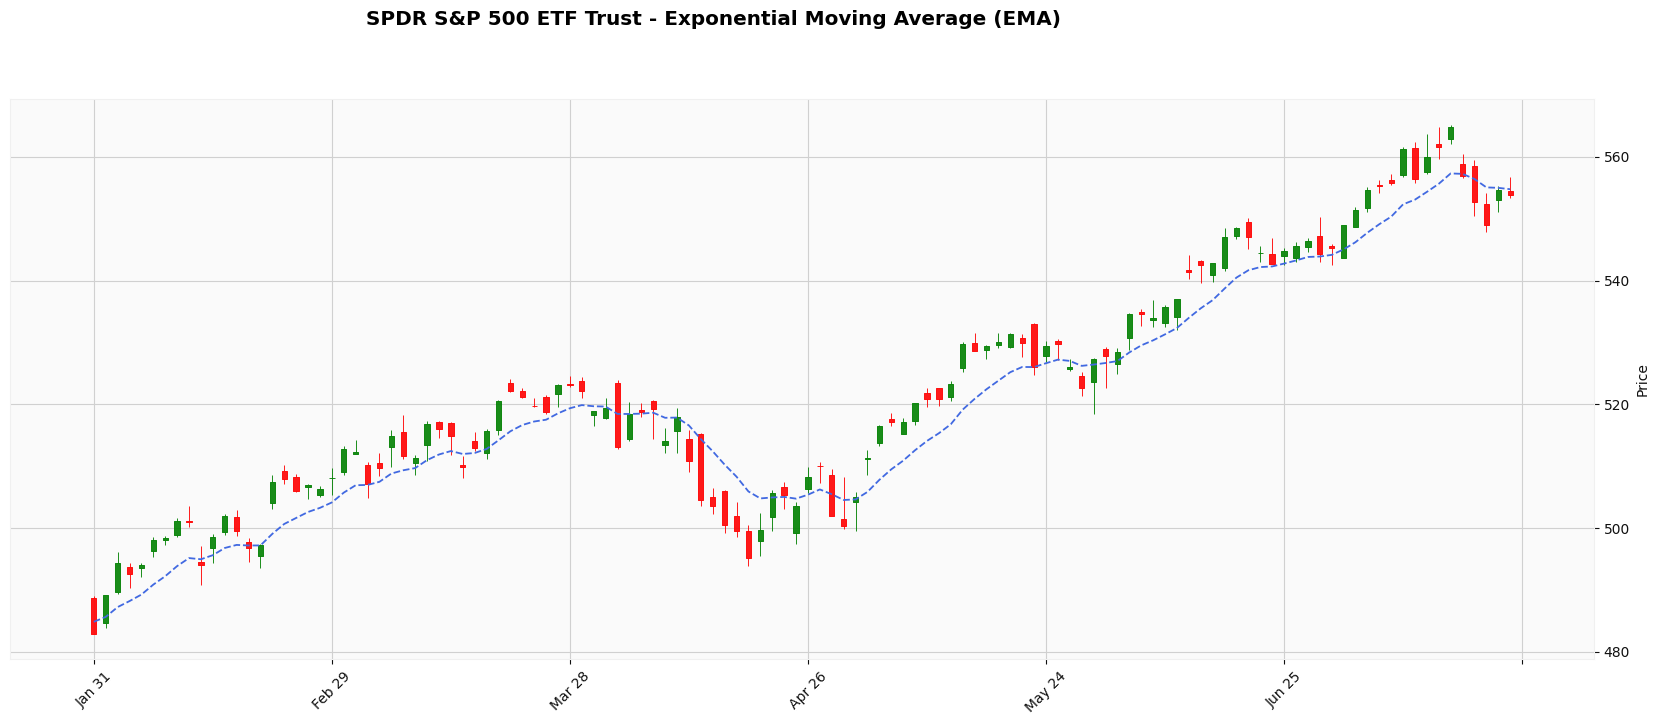

In [ ]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart with Exponential Moving Average
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    addplot=[
        mpf.make_addplot(plot_data['ema_10'], color='royalblue', linestyle='--')
    ],
    title=f'{company_name} - Exponential Moving Average (EMA)',
    figsize=(22, 8)
)

**Interpreting EMA**
- Price above EMA: Uptrend
- Price below EMA: Downtrend
- Price crossing EMA: Potential trend change
- Multiple EMAs: Shorter-term crossing above longer-term indicates bullish trend, vice versa for bearish
- Slope of EMA: Indicates trend strength

Best Used
- Identifying trends and their direction
- Generating buy/sell signals (e.g., crossovers)
- As components in other technical indicators


In [ ]:
def add_ema_signals(df_class, df, n):
  """
  Add EMA Signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added ema signal columns.
  """
  # EMA columns
  ema = f'ema_{n}'

  # Downtrend
  df_class[f'{ema}_Downtrend'] = (df[ema] > df['close']).astype(int)
  # Uptrend
  df_class[f'{ema}_Uptrend'] = (df[ema] < df['close']).astype(int)
  # Crossing above
  df_class[f'{ema}_cross_above'] = (
      (df[ema] > df['close']) & (df[ema] < df['close']).shift(1)).astype(int)
  # Crossing below
  df_class[f'{ema}_cross_below'] = (
      (df[ema] < df['close']) & (df[ema] > df['close']).shift(1)).astype(int)

  return df_class

In [ ]:
df_signals = add_ema_signals(df_signals, df, 10)

df_signals.iloc[:, -4:].tail(20)

,ema_10_Downtrend,ema_10_Uptrend,ema_10_cross_above,ema_10_cross_below
2024-06-25,0,1,0,0
2024-06-26,0,1,0,0
2024-06-27,0,1,0,0
2024-06-28,0,1,0,0
2024-07-01,0,1,0,0
2024-07-02,0,1,0,0
2024-07-03,0,1,0,0
2024-07-05,0,1,0,0
2024-07-08,0,1,0,0
2024-07-09,0,1,0,0


### Triple Exponential Moving Average (TEMA)

In [ ]:
help(ta.tema)

Help on function tema in module pandas_ta.overlap.tema:

tema(close, length=None, talib=None, offset=None, **kwargs)
    Triple Exponential Moving Average (TEMA)
    
    A less laggy Exponential Moving Average.
    
    Sources:
        https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/triple-exponential-moving-average-tema/
    
    Calculation:
        Default Inputs:
            length=10
        EMA = Exponential Moving Average
        ema1 = EMA(close, length)
        ema2 = EMA(ema1, length)
        ema3 = EMA(ema2, length)
        TEMA = 3 * (ema1 - ema2) + ema3
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 10
        talib (bool): If TA Lib is installed and talib is True, Returns the TA Lib
            version. Default: True
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        adjust (bool): Default: True
        presma (bool, optional): If True

In [ ]:
def add_tema(df, fast, mid, slow):
    """
    Calculate the Triple Exponential Moving Average (TEMA) and add it to the DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing intraday stock data.
    - fast (int): The fast look-back period for calculation.
    - mid (int): The mid look-back period for calculation.
    - slow (int): The slow look-back period for calculation.

    Returns:
    - df (pandas.DataFrame): The same DataFrame with added 'tema' column.
    """
    # Calculate the TEMA
    df[f'tema_{fast}'] = ta.tema(close=df['close'], length=fast)
    df[f'tema_{mid}'] = ta.tema(close=df['close'], length=mid)
    df[f'tema_{slow}'] = ta.tema(close=df['close'], length=slow)

    return df

In [ ]:
df = add_tema(df, fast=5, mid=20, slow=50)

df.iloc[:, -3:].tail()

,tema_5,tema_20,tema_50
2024-07-17,559.670019,562.271734,560.151070
2024-07-18,554.524472,560.637514,560.148970
2024-07-19,549.786459,558.272449,559.702634
2024-07-22,551.982147,557.744721,559.902336
2024-07-23,552.634044,557.039127,559.960729


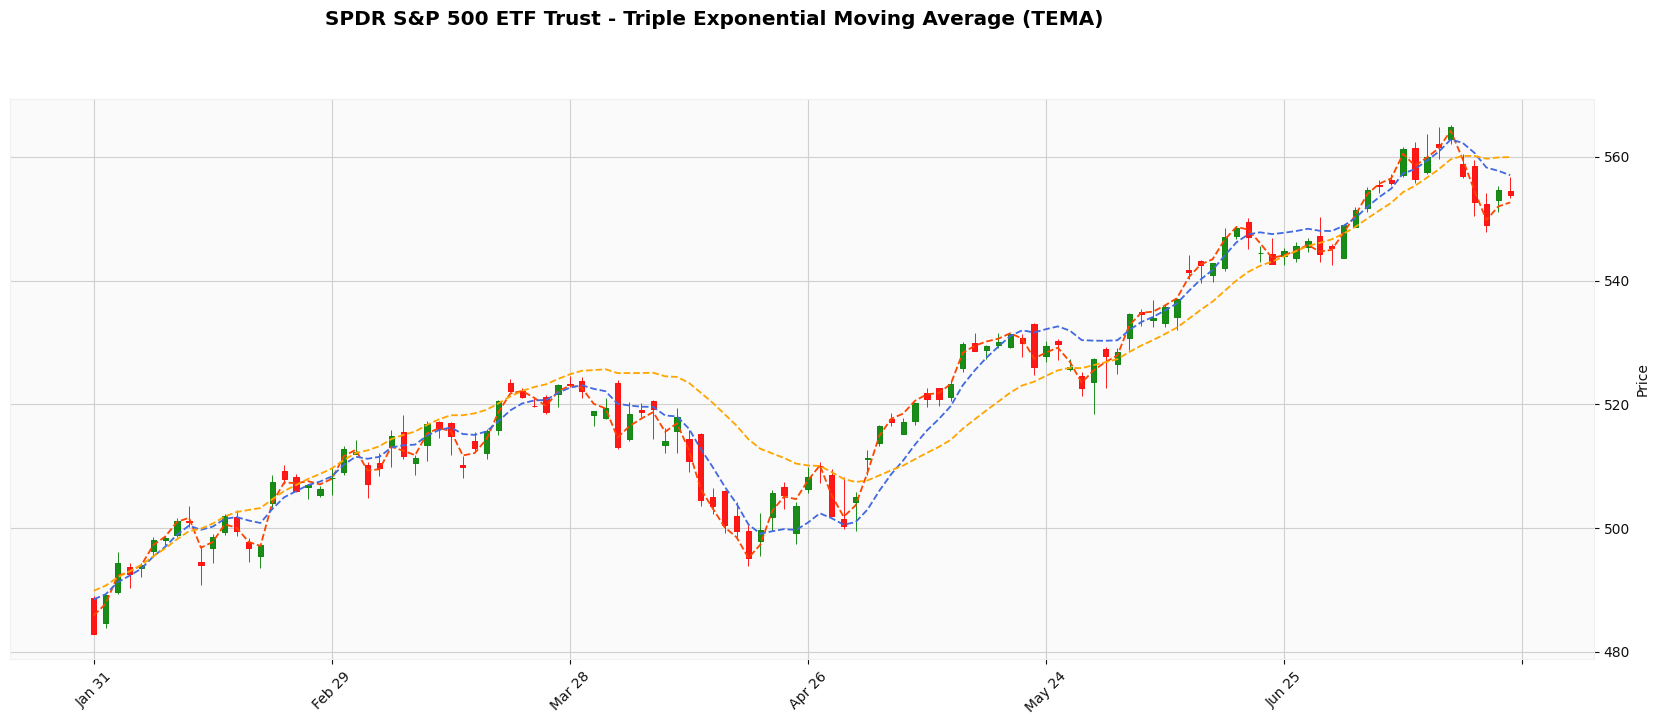

In [ ]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart with Triple Exponential Moving Average
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    addplot=[
        mpf.make_addplot(plot_data['tema_5'], color='orangered', linestyle='--'),
        mpf.make_addplot(plot_data['tema_20'], color='royalblue', linestyle='--'),
        mpf.make_addplot(plot_data['tema_50'], color='orange', linestyle='--')
    ],
    title=f'{company_name} - Triple Exponential Moving Average (TEMA)',
    figsize=(22, 8)
)

**Interpreting TEMA:**

- Price above TEMA: uptrend
- Price below TEMA: downtrend
- Price crossing TEMA: Potential trend reversal
- TEMA slope: Indicates trend strength and direction
- TEMA vs EMA: TEMA responds faster to price changes

**Best Used**

- Identifying trends with reduced lag
- Generating more responsive buy/sell signals
- Filtering out market noise
- Confirming trend strength in conjunction with other indicators

In [ ]:
def add_tema_signals(df_class, df, fast, mid, slow):
  """
  Add TEMA Signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - fast (int): The fast look-back period for calculation.
  - mid (int): The mid look-back period for calculation.
  - slow (int): The slow look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added tema signal columns.
  """
  # TEMA columns
  tema_fast = f'tema_{fast}'
  tema_mid = f'tema_{mid}'
  tema_slow = f'tema_{slow}'

  # Bullish Trend Signal
  df_class[f'tema_{fast}_{mid}_{slow}_bullish_trend'] = (
      (df['close'] > df[tema_fast]) &
      (df['close'] > df[tema_mid]) &
      (df['close'] > df[tema_slow]) &
      (df[tema_fast] > df[tema_mid]) &
      (df[tema_mid] > df[tema_slow])
      ).astype(int)

  # Bearish Trend Signal
  df_class[f'tema_{fast}_{mid}_{slow}_bearish_trend'] = (
      (df['close'] < df[tema_fast]) &
      (df['close'] < df[tema_mid]) &
      (df['close'] < df[tema_slow]) &
      (df[tema_fast] < df[tema_mid]) &
      (df[tema_mid] < df[tema_slow])
      ).astype(int)

  # Fast crossup mid (buy short)
  df_class[f'tema_{fast}_crossup_{mid}'] = (
      (df[tema_fast] > df[tema_mid]) &
      (df[tema_fast] < df[tema_mid]).shift(1)
      ).astype(int)

  # Mid crossup slow
  df_class[f'tema_{mid}_crossup_{slow}'] = (
      (df[tema_mid] > df[tema_slow]) &
      (df[tema_mid] < df[tema_slow]).shift(1)
      ).astype(int)

  # Fast crossdown mid
  df_class[f'tema_{fast}_crossdown_{mid}'] = (
      (df[tema_fast] < df[tema_mid]) &
      (df[tema_fast] > df[tema_mid]).shift(1)
      ).astype(int)

  # Mid crossdown slow
  df_class[f'tema_{mid}_crossdown_{slow}'] = (
      (df[tema_mid] < df[tema_slow]) &
      (df[tema_mid] > df[tema_slow]).shift(1)
      ).astype(int)



  return df_class

In [ ]:
df_signals = add_tema_signals(df_signals, df, fast=5, mid=20, slow=50)

df_signals.iloc[:, -6:].tail()

,tema_5_20_50_bullish_trend,tema_5_20_50_bearish_trend,tema_5_crossup_20,tema_20_crossup_50,tema_5_crossdown_20,tema_20_crossdown_50
2024-07-17,0,0,0,0,1,0
2024-07-18,0,0,0,0,0,0
2024-07-19,0,1,0,0,0,1
2024-07-22,0,0,0,0,0,0
2024-07-23,0,0,0,0,0,0


### McGinley Dynamic

In [ ]:
help(ta.mcgd)

Help on function mcgd in module pandas_ta.overlap.mcgd:

mcgd(close, length=None, offset=None, c=None, **kwargs)
    McGinley Dynamic Indicator
    
    The McGinley Dynamic looks like a moving average line, yet it is actually a
    smoothing mechanism for prices that minimizes price separation, price whipsaws,
    and hugs prices much more closely. Because of the calculation, the Dynamic Line
    speeds up in down markets as it follows prices yet moves more slowly in up
    markets. The indicator was designed by John R. McGinley, a Certified Market
    Technician and former editor of the Market Technicians Association's Journal
    of Technical Analysis.
    
    Sources:
        https://www.investopedia.com/articles/forex/09/mcginley-dynamic-indicator.asp
    
    Calculation:
        Default Inputs:
            length=10
            offset=0
            c=1
    
        def mcg_(series):
            denom = (constant * length * (series.iloc[1] / series.iloc[0]) ** 4)
            ser

In [ ]:
def add_mcgd(df, n=10):
    """
    Calculate the McGinley Dynamic and add it to the DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing intraday stock data.
    - n (int): The period of the McGinley Dynamic.

    Returns:
    - df (pandas.DataFrame): The same DataFrame with added 'mcgd' column.
    """
    # Initialize the McGinley Dynamic list with the first close price
    md = [df['close'].iloc[0]]

    # Loop through the close prices starting from the second one
    for i in range(1, len(df['close'])):
        price = df['close'].iloc[i]
        prev_md = md[-1]

        # Calculate the McGinley Dynamic for the current period
        md_value = prev_md + (price - prev_md) / (n * (price / prev_md) ** 4)

        # Append the calculated value to the list
        md.append(md_value)

    # Update the DataFrame with the new McGinley Dynamic values
    df[f'mcgd_{n}'] = md

    return df

In [ ]:
df = add_mcgd(df, n=10)

df.iloc[:, -3:].tail()


,tema_20,tema_50,mcgd_10
2024-07-17,562.271734,560.151070,551.879961
2024-07-18,560.637514,560.148970,551.957526
2024-07-19,558.272449,559.702634,551.654305
2024-07-22,557.744721,559.902336,551.947454
2024-07-23,557.039127,559.960729,552.128295


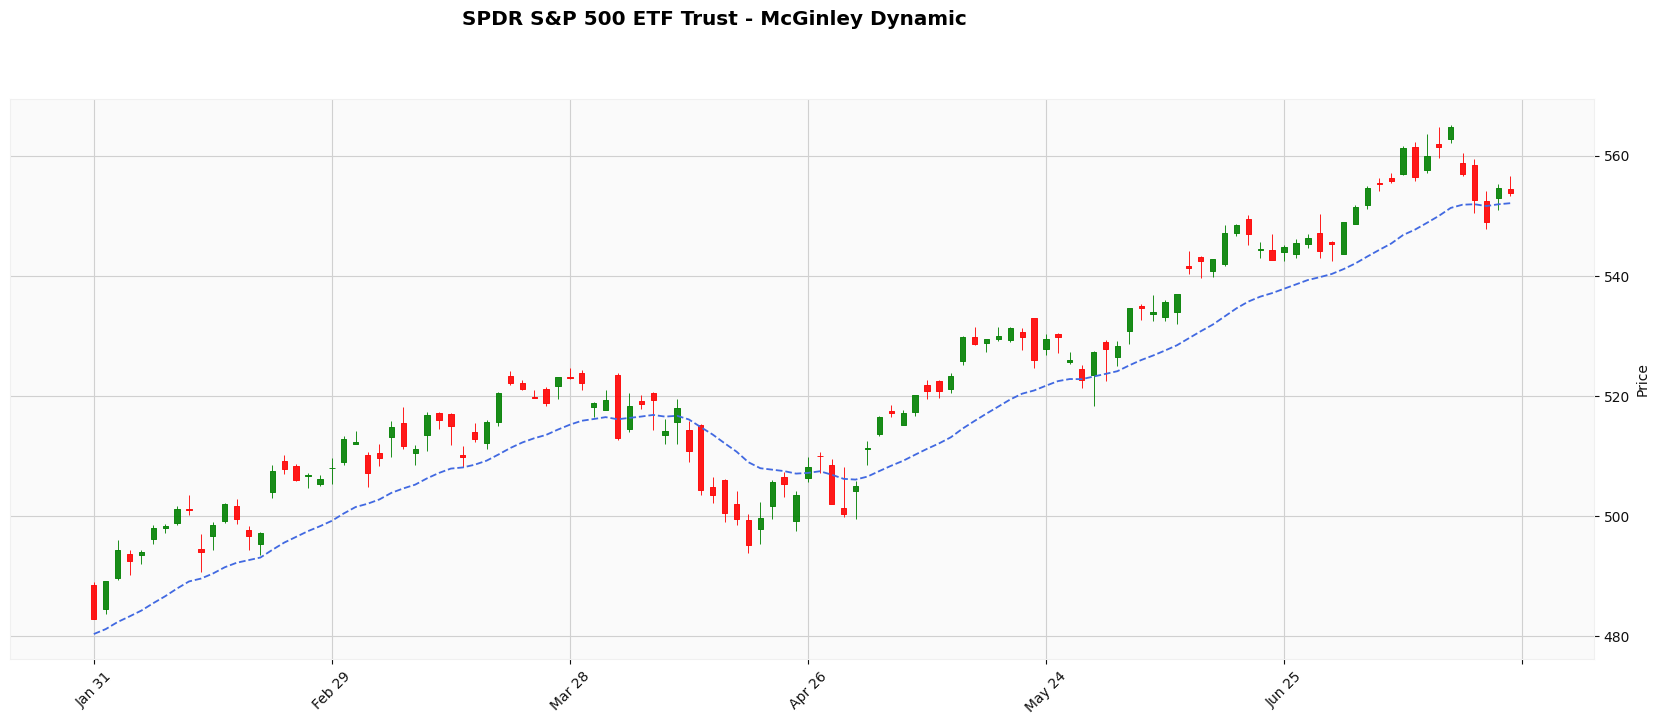

In [ ]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart with McGinley Dynamic
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    addplot=[
        mpf.make_addplot(plot_data['mcgd_10'], color='royalblue', linestyle='--')
    ],
    title=f'{company_name} - McGinley Dynamic',
    figsize=(22, 8)
)

**Interpreting McGinley Dynamic**

**Key Signals**
- **Price above McGinley:** Bullish trend
- **Price below McGinley:** Bearish trend
- **Price crossing McGinley:** Potential trend change
- **Slope of McGinley:** Indicates trend strength

**Characteristics**
- Adapts to market volatility
- Reduces whipsaws compared to traditional MAs
- Responds more quickly to price changes

**Best Used For**
- Identifying trends with less lag
- Generating more accurate buy/sell signals
- Confirming trend strength
- Dynamic support/resistance levels
- Markets with varying volatility

**Comparison**
- More responsive than traditional MAs
- Less prone to false signals in choppy markets

In [ ]:
def add_mcgd_signals(df_class, df, n):
  """
  Add McGinley Dynamic Signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added mcgd signal columns.
  """
  # McGinley Dynamic columns
  mcgd = f'mcgd_{n}'

  # Bullish trend
  df_class[f'{mcgd}_bullish'] = (df[mcgd] < df['close']).astype(int)
  # Bearish trend
  df_class[f'{mcgd}_bearish'] = (df[mcgd] > df['close']).astype(int)


  return df_class

In [ ]:
df_signals = add_mcgd_signals(df_signals, df, 10)

df_signals.iloc[:, -4:].tail()

,tema_5_crossdown_20,tema_20_crossdown_50,mcgd_10_bullish,mcgd_10_bearish
2024-07-17,1,0,1,0
2024-07-18,0,0,1,0
2024-07-19,0,1,0,1
2024-07-22,0,0,1,0
2024-07-23,0,0,1,0


### Supertrend

In [ ]:
help(ta.supertrend)

Help on function supertrend in module pandas_ta.overlap.supertrend:

supertrend(high, low, close, length=None, multiplier=None, offset=None, **kwargs)
    Supertrend (supertrend)
    
    Supertrend is an overlap indicator. It is used to help identify trend
    direction, setting stop loss, identify support and resistance, and/or
    generate buy & sell signals.
    
    Sources:
        http://www.freebsensetips.com/blog/detail/7/What-is-supertrend-indicator-its-calculation
    
    Calculation:
        Default Inputs:
            length=7, multiplier=3.0
        Default Direction:
            Set to +1 or bullish trend at start
    
        MID = multiplier * ATR
        LOWERBAND = HL2 - MID
        UPPERBAND = HL2 + MID
    
        if UPPERBAND[i] < FINAL_UPPERBAND[i-1] and close[i-1] > FINAL_UPPERBAND[i-1]:
            FINAL_UPPERBAND[i] = UPPERBAND[i]
        else:
            FINAL_UPPERBAND[i] = FINAL_UPPERBAND[i-1])
    
        if LOWERBAND[i] > FINAL_LOWERBAND[i-1] and clos

In [ ]:
def add_supertrend(df, n=10, multiplier=3):
  """
  Calculate the Supertrend and add it to the DataFrame.

  Parameters:
  - df (pandas.DataFrame): The DataFrame containing stock data.
  - n (int): The look-back period for calculation.
  - multiplier (float): The multiplier for the Supertrend.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added 'supertrend' column.
  """
  # Calculate the Supertrend
  supertrend = ta.supertrend(
      high=df['high'], low=df['low'], close=df['close'], length=n, multiplier=multiplier)

  df[supertrend.columns[:2]] = supertrend[supertrend.columns[:2]]

  return df


In [ ]:
df = add_supertrend(df, n=7, multiplier=1.5)

df.iloc[:, -4:].tail()

,tema_50,mcgd_10,SUPERT_7_1.5,SUPERTd_7_1.5
2024-07-17,560.151070,551.879961,556.731758,1
2024-07-18,560.148970,551.957526,563.506260,-1
2024-07-19,559.702634,551.654305,559.629651,-1
2024-07-22,559.902336,551.947454,559.629651,-1
2024-07-23,559.960729,552.128295,559.629651,-1


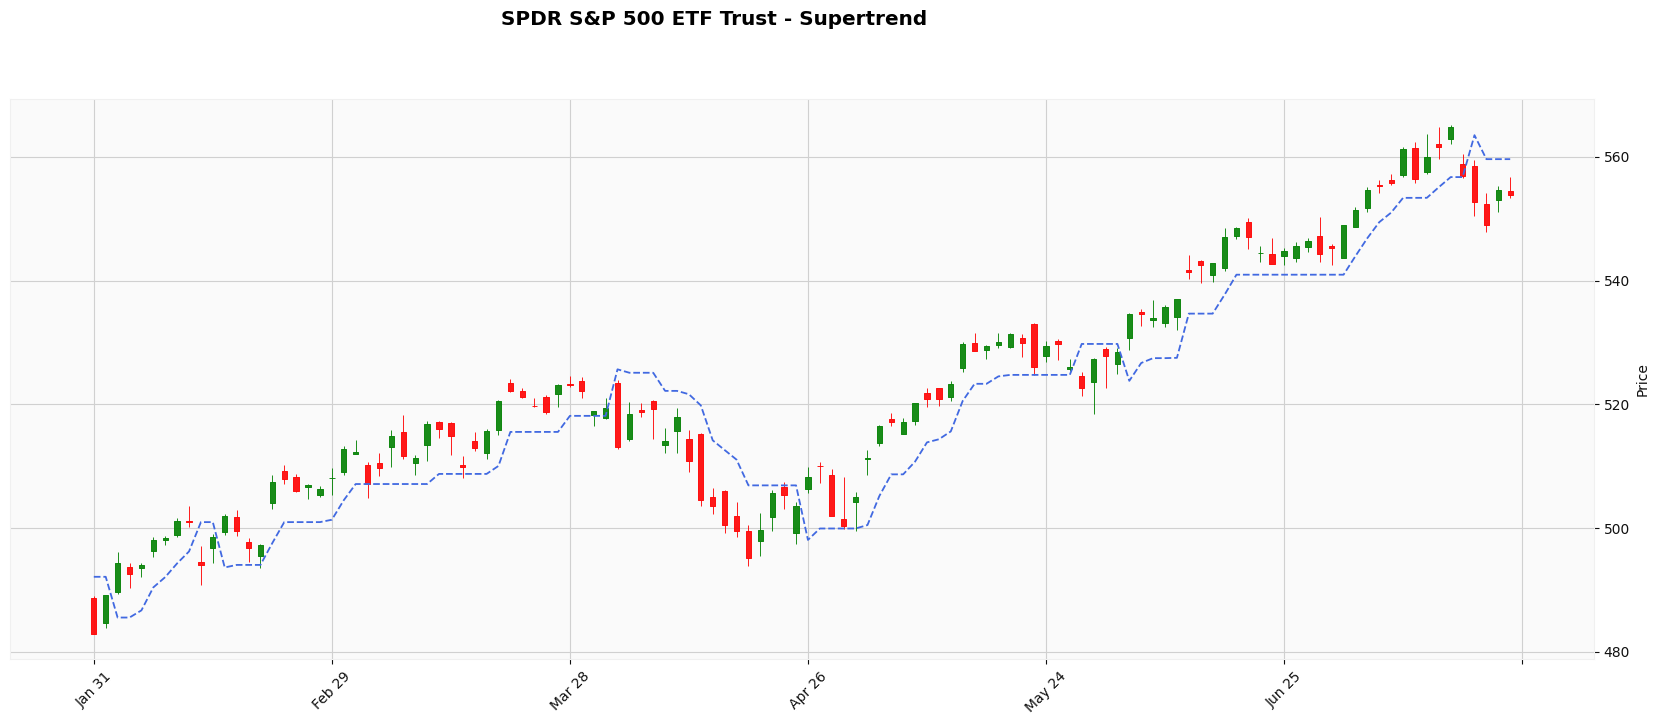

In [ ]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart with Supertrend
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    addplot=[
        mpf.make_addplot(plot_data['SUPERT_7_1.5'], color='royalblue', linestyle='--')
    ],
    title=f'{company_name} - Supertrend',
    figsize=(22, 8)
)

**Interpreting Supertrend:**

- Price above Supertrend Line: Potential uptrend
- Price below Supertrend Line: Potential downtrend

In [ ]:
def add_supertrend_signals(df_class, df, n, multiplier):
  """
  Add Supertrend Signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for calculation.
  - multiplier (float): The multiplier for the Supertrend.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added supertrend signal columns.
  """
  # Supertrend columns
  supertrend = f'SUPERT_{n}_{multiplier}'

  # Uptrend
  df_class[f'{supertrend}_uptrend'] = (df[supertrend] < df['close']).astype(int)
  # Downtrend
  df_class[f'{supertrend}_downtrend'] = (df[supertrend] > df['close']).astype(int)

  return df_class

In [ ]:
df_signals = add_supertrend_signals(df_signals, df, 7, 1.5)

df_signals.iloc[:, -4:].tail(20)

,mcgd_10_bullish,mcgd_10_bearish,SUPERT_7_1.5_uptrend,SUPERT_7_1.5_downtrend
2024-06-25,1,0,1,0
2024-06-26,1,0,1,0
2024-06-27,1,0,1,0
2024-06-28,1,0,1,0
2024-07-01,1,0,1,0
2024-07-02,1,0,1,0
2024-07-03,1,0,1,0
2024-07-05,1,0,1,0
2024-07-08,1,0,1,0
2024-07-09,1,0,1,0


## Volatility Indicators

### Average True Range (ATR)

In [ ]:
help(ta.atr)

Help on function atr in module pandas_ta.volatility.atr:

atr(high, low, close, length=None, mamode=None, talib=None, drift=None, offset=None, **kwargs)
    Average True Range (ATR)
    
    Averge True Range is used to measure volatility, especially volatility caused by
    gaps or limit moves.
    
    Sources:
        https://www.tradingview.com/wiki/Average_True_Range_(ATR)
    
    Calculation:
        Default Inputs:
            length=14, drift=1, percent=False
        EMA = Exponential Moving Average
        SMA = Simple Moving Average
        WMA = Weighted Moving Average
        RMA = WildeR's Moving Average
        TR = True Range
    
        tr = TR(high, low, close, drift)
        if 'ema':
            ATR = EMA(tr, length)
        elif 'sma':
            ATR = SMA(tr, length)
        elif 'wma':
            ATR = WMA(tr, length)
        else:
            ATR = RMA(tr, length)
    
        if percent:
            ATR *= 100 / close
    
    Args:
        high (pd.Series):

In [ ]:
# Define the Average True Range function
def add_atr(df, n):
    """
    Calculate the Average True Range (ATR) and add it to the DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing intraday stock data.
    - n (int): The look-back period for the ATR calculation.

    Returns:
    - df (pandas.DataFrame): The same DataFrame with added 'atr' column.
    """
    # Sort the data index to ensure consistency
    df.sort_index(ascending=True, inplace=True)

    # Calculate the ATR
    df[f'atr_{n}'] = ta.atr(
        high=df['high'], low=df['low'], close=df['close'], length=n
        )

    return df

In [ ]:
df = add_atr(df, n=5)

df.iloc[:, -1:].tail()

,atr_5
2024-07-17,5.422566
2024-07-18,6.156053
2024-07-19,6.158843
2024-07-22,6.183074
2024-07-23,5.638459


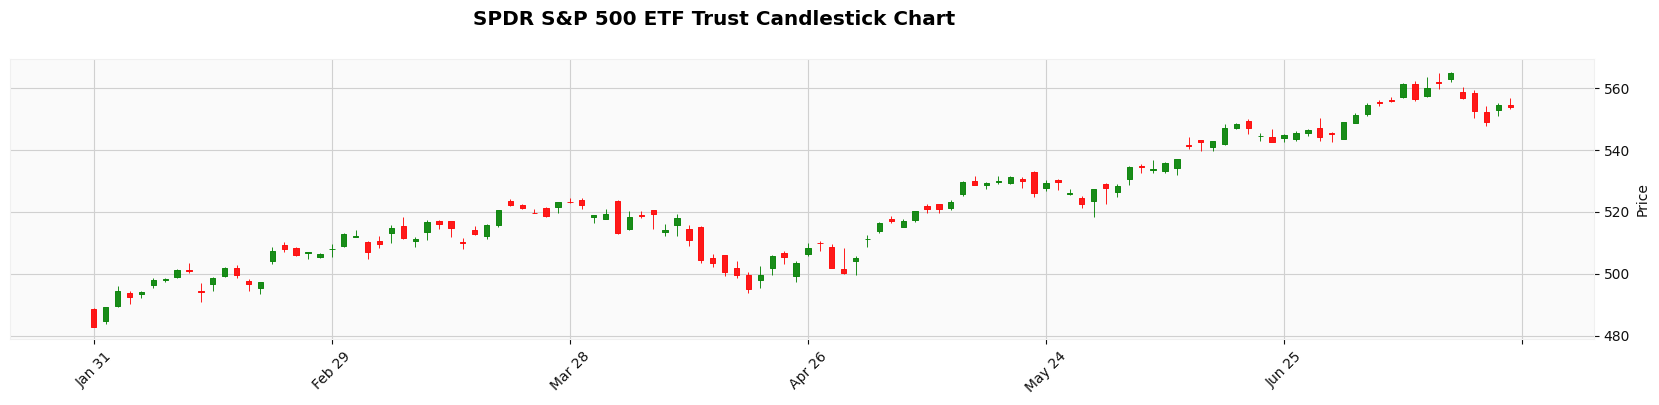

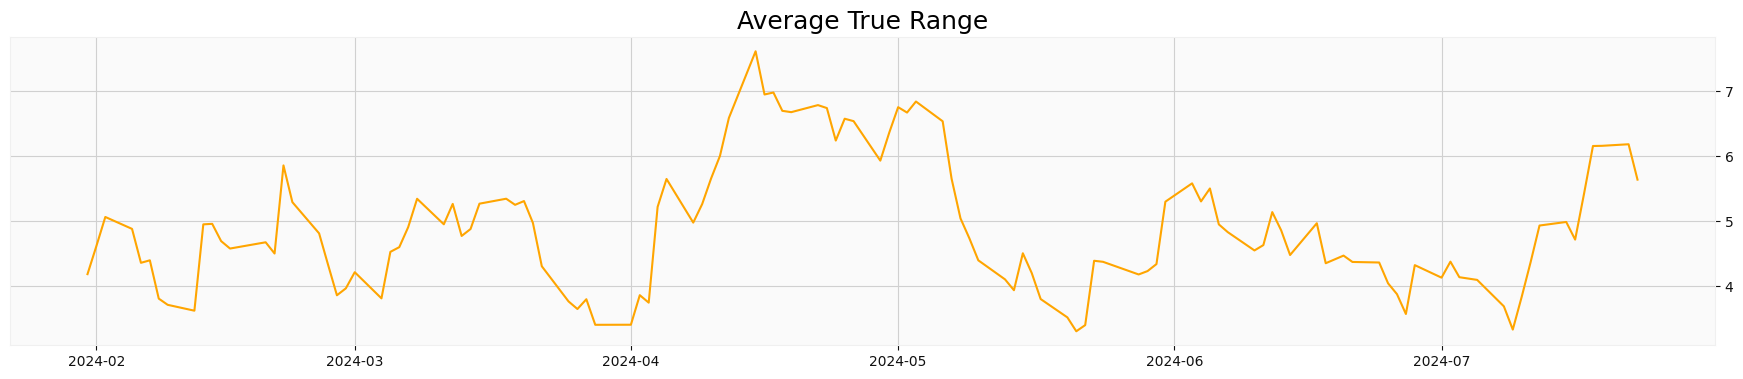

In [ ]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    title= f'{company_name} Candlestick Chart',
    figsize=(22, 4)
)

# Set figure size
plt.figure(figsize=(22, 4))

# Create a new subplot
ax = plt.gca()

# Plot Average True Range
ax.plot(plot_data.index, plot_data['atr_5'], color='orange')

# Move Y axis ticks to the right
ax.yaxis.tick_right()
# Set label position to the right
ax.yaxis.set_label_position("right")

# Set title
ax.set_title('Average True Range', loc='center', fontsize=18)

# Display the plot
plt.show();

**ATR-Based Trading Signals**
- Volatility Breakout
  - Buy Signal: When the price breaks above a resistance level plus a multiple of the ATR (e.g., resistance + 1.5 × ATR).
  - Sell Signal: When the price breaks below a support level minus a multiple of the ATR (e.g., support - 1.5 × ATR).


In [ ]:
def add_atr_signals(df_class, df, n, p):
  """
  Add ATR Signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for calculation.
  - p (float): The multiplier for the ATR.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added atr signal columns.
  """
  # ATR columns
  atr = f'atr_{n}'

  # Calculate ATR percentage
  ATR_Percent = df[atr] / df['close'].shift(1)

  # Buy Signal
  df_class[f'{atr}_buy'] = (df['close'] > df['close'].shift(1) * (1 + ATR_Percent * p)).astype(int)
  # Sell Signal
  df_class[f'{atr}_sell'] = (df['close'] < df['close'].shift(1) * (1 - ATR_Percent * p)).astype(int)



  return df_class

In [ ]:
df_signals = add_atr_signals(df_signals, df, 5, 0.5)

df_signals.iloc[:, -6:].tail()

,mcgd_10_bullish,mcgd_10_bearish,SUPERT_7_1.5_uptrend,SUPERT_7_1.5_downtrend,atr_5_buy,atr_5_sell
2024-07-17,1,0,1,0,0,1
2024-07-18,1,0,0,1,0,1
2024-07-19,0,1,0,1,0,1
2024-07-22,1,0,0,1,1,0
2024-07-23,1,0,0,1,0,0


### Bollinger Bands

In [ ]:
help(ta.bbands)

Help on function bbands in module pandas_ta.volatility.bbands:

bbands(close, length=None, std=None, ddof=0, mamode=None, talib=None, offset=None, **kwargs)
    Bollinger Bands (BBANDS)
    
    A popular volatility indicator by John Bollinger.
    
    Sources:
        https://www.tradingview.com/wiki/Bollinger_Bands_(BB)
    
    Calculation:
        Default Inputs:
            length=5, std=2, mamode="sma", ddof=0
        EMA = Exponential Moving Average
        SMA = Simple Moving Average
        STDEV = Standard Deviation
        stdev = STDEV(close, length, ddof)
        if "ema":
            MID = EMA(close, length)
        else:
            MID = SMA(close, length)
    
        LOWER = MID - std * stdev
        UPPER = MID + std * stdev
    
        BANDWIDTH = 100 * (UPPER - LOWER) / MID
        PERCENT = (close - LOWER) / (UPPER - LOWER)
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): The short period. Default: 5
        std (int): The long 

In [ ]:
# Define the Bollinger Bands function
def add_bbands(df, n, std):
    """
    Calculate Bollinger Bands and add it to the DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing intraday stock data.
    - n (int): The length of the period for the Bollinger Bands.
    - std (float): The standard deviation for the Bollinger Bands.

    Returns:
    - df (pandas.DataFrame): The same DataFrame with added Bollinger Bands columns.
    """
    # Calculate Bollinger Bands
    bol_bands = ta.bbands(close=df['close'], length=n, std=std)
    # Add Bollinger Bands to the DataFrame
    df[bol_bands.columns] = bol_bands[bol_bands.columns]

    print(bol_bands.columns)

    return df

In [ ]:
# Calculate the Bollinger Bands
df = add_bbands(df, n=10, std=1.5)

df.iloc[:, -5:].tail()

Index(['BBL_10_1.5', 'BBM_10_1.5', 'BBU_10_1.5', 'BBB_10_1.5', 'BBP_10_1.5'], dtype='object')


,BBL_10_1.5,BBM_10_1.5,BBU_10_1.5,BBB_10_1.5,BBP_10_1.5
2024-07-17,552.142534,557.832,563.521466,2.039849,0.421610
2024-07-18,552.546379,557.952,563.357621,1.937665,0.010510
2024-07-19,550.745780,557.387,564.028220,2.382984,-0.132188
2024-07-22,550.631951,557.324,564.016049,2.401493,0.300211
2024-07-23,550.263841,557.120,563.976159,2.461286,0.256423


In [ ]:
df.iloc[:, -5:].describe()

,BBL_10_1.5,BBM_10_1.5,BBU_10_1.5,BBB_10_1.5,BBP_10_1.5
count,6211.000000,6211.000000,6211.000000,6211.000000,6211.000000
mean,200.454178,203.886996,207.319814,3.527135,0.571732
std,112.464266,114.183859,115.960484,2.518402,0.413401
min,67.221375,71.247000,74.646399,0.285015,-0.476458
25%,118.087806,120.166500,122.046280,1.910275,0.221812
50%,144.158130,146.787000,149.288366,2.916418,0.647480
75%,262.926943,268.204000,274.001880,4.351875,0.920288
max,552.546379,557.952000,564.028220,27.421563,1.414756


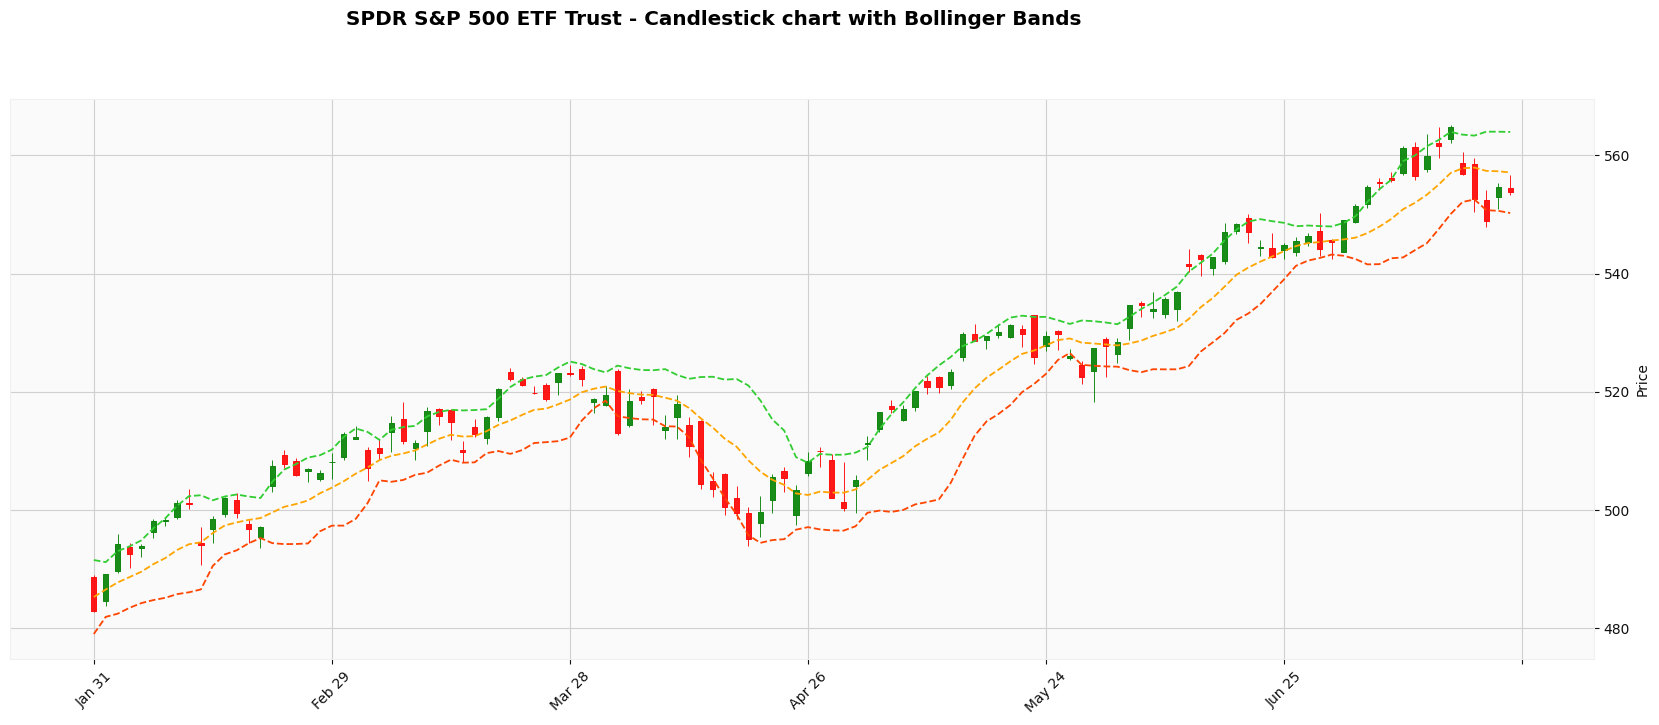

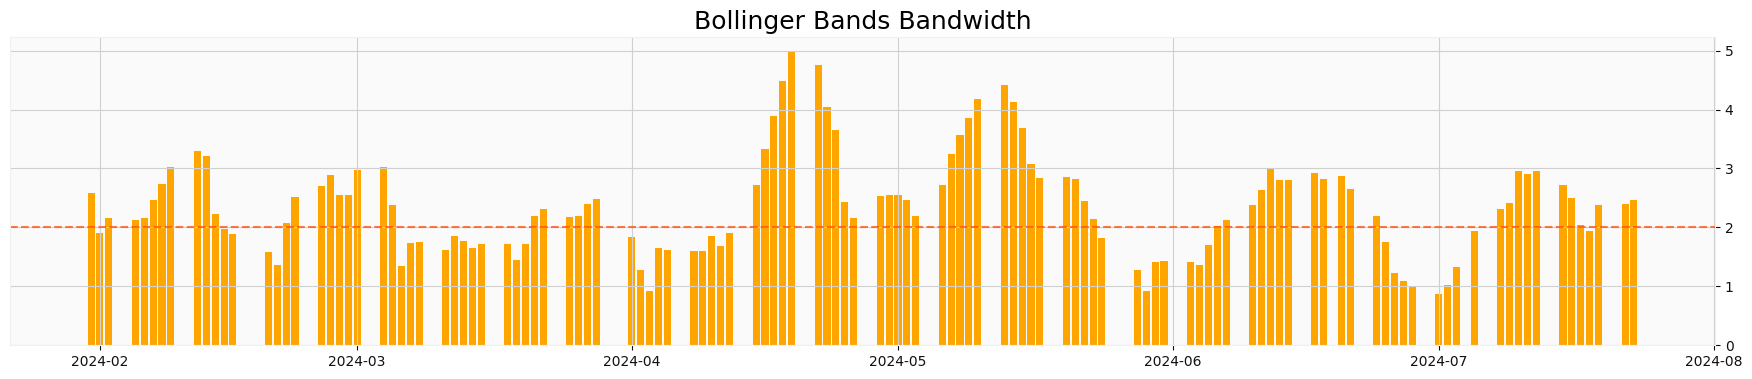

In [ ]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart with bollinger bands
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    addplot=[
        mpf.make_addplot(plot_data['BBL_10_1.5'], color='orangered', linestyle='--'),
        mpf.make_addplot(plot_data['BBM_10_1.5'], color='orange', linestyle='--'),
        mpf.make_addplot(plot_data['BBU_10_1.5'], color='limegreen', linestyle='--'),

    ],
    title=f'{company_name} - Candlestick chart with Bollinger Bands',
    figsize=(22, 8)
)

# Set figure size
plt.figure(figsize=(22, 4))

# Create a new subplot
ax = plt.gca()

# Plot Average True Range
ax.bar(plot_data.index, plot_data['BBB_10_1.5'], color='orange')

# Set constant line at 2 to identify the squeeze
plt.axhline(2, color='orangered', linestyle='--', label='Squeeze', alpha=0.7)

# Move Y axis ticks to the right
ax.yaxis.tick_right()
# Set label position to the right
ax.yaxis.set_label_position("right")

# Set title
ax.set_title('Bollinger Bands Bandwidth', loc='center', fontsize=18)

# Display the plot
plt.show();

**Interpreting Bollinger Bands:**
- **Price Exceeding Bands**: If the price moves outside the bands, it may indicate that the asset is overbought (above the upper band) or oversold (below the lower band).
- **Band Expansion and Contraction**: Wider bands indicate higher volatility, while narrower bands indicate lower volatility.
- **Reversion to the Mean**: Prices tend to revert to the middle band after touching or exceeding the upper or lower bands.

In [ ]:
def add_bbands_signal(df_class, df, n, std):
  """
  Add Bollinger Bands signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added bbands signal columns.
  """
  # Bollinger Bands columns
  bb_up = f'BBU_{n}_{std}'
  bb_mid = f'BBM_{n}_{std}'
  bb_low = f'BBL_{n}_{std}'
  bb_percent = f'BBP_{n}_{std}'
  bb_width = f'BBB_{n}_{std}'

  # Overbought
  df_class[f'bbands_{n}_{std}_ob'] = (df['close'] > df[bb_up]).astype(int)
  # Oversold
  df_class[f'bbands_{n}_{std}_os'] = (df['close'] < df[bb_low]).astype(int)
  # Squeez
  df_class['bb_squeeze'] = (df[bb_width] <= 2).astype(int)
  # BB percent overbought
  df_class['bb_%B_overbought'] = (df[bb_percent] < 0).astype(int)
  # BB percent oversold
  df_class[f'bb_%B_oversold'] = (df[bb_percent] > 1).astype(int)
  # BB percent, price above 0.5
  df_class[f'bb_%B_above_0.5'] = (df[bb_percent] > 0.5).astype(int)
  # BB percent, price below 0.5
  df_class[f'bb_%B_below_0.5'] = (df[bb_percent] < 0.5).astype(int)

  return df_class

In [ ]:
df_signals = add_bbands_signal(df_signals, df, 10, 1.5)

df_signals.iloc[:, -7:].tail()

,bbands_10_1.5_ob,bbands_10_1.5_os,bb_squeeze,bb_%B_overbought,bb_%B_oversold,bb_%B_above_0.5,bb_%B_below_0.5
2024-07-17,0,0,0,0,0,0,1
2024-07-18,0,0,1,0,0,0,1
2024-07-19,0,1,0,1,0,0,1
2024-07-22,0,0,0,0,0,0,1
2024-07-23,0,0,0,0,0,0,1


## Trend Indicators

### Average Directional Index (ADX)

In [ ]:
help(ta.adx)

Help on function adx in module pandas_ta.trend.adx:

adx(high, low, close, length=None, lensig=None, scalar=None, mamode=None, drift=None, offset=None, **kwargs)
    Average Directional Movement (ADX)
    
    Average Directional Movement is meant to quantify trend strength by measuring
    the amount of movement in a single direction.
    
    Sources:
        https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/average-directional-movement-adx/
        TA Lib Correlation: >99%
    
    Calculation:
        DMI ADX TREND 2.0 by @TraderR0BERT, NETWORTHIE.COM
            //Created by @TraderR0BERT, NETWORTHIE.COM, last updated 01/26/2016
            //DMI Indicator
            //Resolution input option for higher/lower time frames
            study(title="DMI ADX TREND 2.0", shorttitle="ADX TREND 2.0")
    
            adxlen = input(14, title="ADX Smoothing")
            dilen = input(14, title="DI Length")
            thold = input(20, title="Threshold")
  

In [ ]:
def add_adx(df, n=14):
  """
  Calculate the Average Directional Index (ADX) and add it to the DataFrame.

  Parameters:
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for the ADX calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added 'adx' column.
  """
  # Calculate the Average Directional Index
  adx = ta.adx(high=df['high'], low=df['low'], close=df['close'], length=n)

  # Add the calculated ADX as a new column to the DataFrame
  df[adx.columns] = adx[adx.columns]

  return df


In [ ]:
df = add_adx(df, 7)

df.iloc[:, -4:].tail()

,BBP_10_1.5,ADX_7,DMP_7,DMN_7
2024-07-17,0.421610,63.381275,24.146164,18.027210
2024-07-18,0.010510,57.536865,18.633112,29.433983
2024-07-19,-0.132188,54.002336,15.779999,31.180905
2024-07-22,0.300211,49.676035,16.267561,26.383679
2024-07-23,0.256423,44.387769,18.613996,24.009329


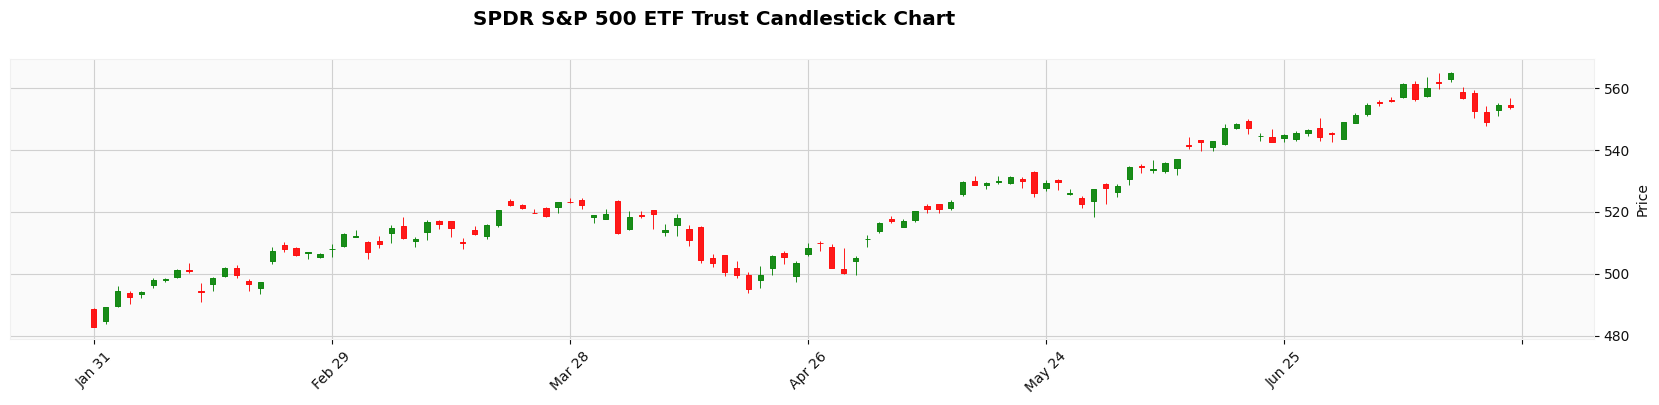

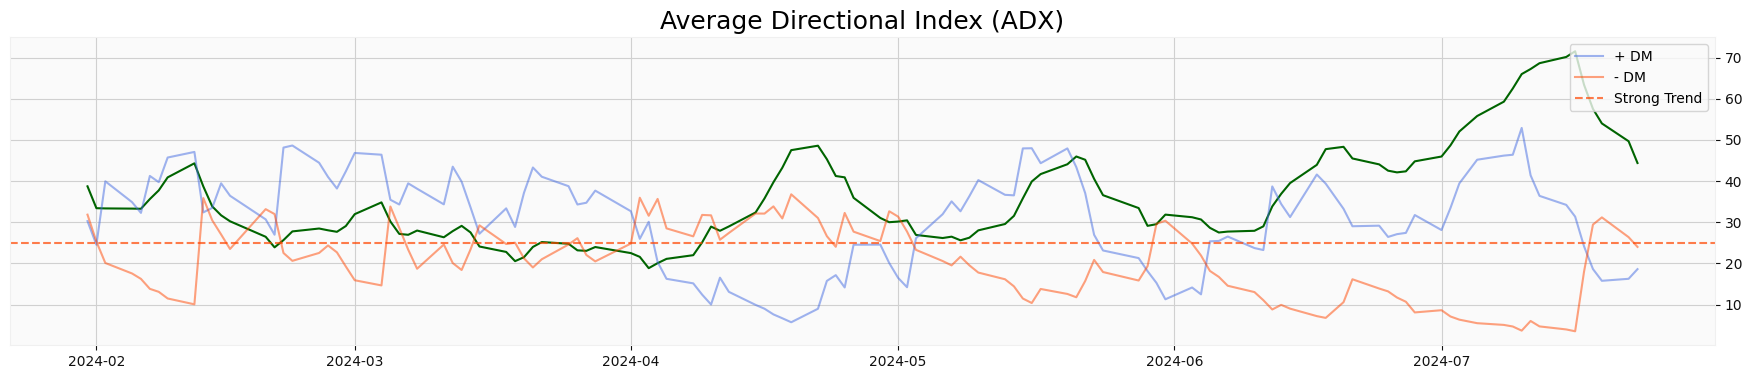

In [ ]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    title= f'{company_name} Candlestick Chart',
    figsize=(22, 4)
)

# Set figure size
plt.figure(figsize=(22, 4))

# Create a new subplot
ax = plt.gca()

# Plot ADX and DMI's
ax.plot(plot_data.index, plot_data['ADX_7'], color='darkgreen')
ax.plot(plot_data.index, plot_data['DMP_7'], color='royalblue', label='+ DM', alpha=0.5)
ax.plot(plot_data.index, plot_data['DMN_7'], color='orangered', label='- DM', alpha=0.5)


# Set constant lines
plt.axhline(25, color='orangered', linestyle='--', label='Strong Trend', alpha=0.7)



# Show Legend
ax.legend(loc='upper right')

# Set title
ax.set_title('Average Directional Index (ADX)', loc='center', fontsize=18)

# Move Y axis ticks to the right
ax.yaxis.tick_right()
# Set label position to the right
ax.yaxis.set_label_position("right")

plt.show();

**Interpreting ADX**
- 0-25	Absent or Weak Trend
- 25-50	Strong Trend
- 50-75	Very Strong Trend
- 75-100	Extremely Strong Trend
- Crossovers of +DI and -DI: Potential trade signals

Best Used
- Identifying strong trends
- Filtering out weak trends
- Confirming trend persistence


In [ ]:
def add_adx_signals(df_class, df, n):
  """
  Add ADX signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added adx signal columns.
  """
  # ADX columns
  adx = f'ADX_{n}'
  dmp = f'DMP_{n}'
  dmn = f'DMN_{n}'

  # Weak trend
  df_class[f'{adx}_weak'] = (df[adx] < 25).astype(int)
  # Strong trend
  df_class[f'{adx}_strong'] = ((df[adx] > 25) & (df[adx] < 75)).astype(int)
  # Very Strong Trend
  df_class[f'{adx}_very_strong'] = (df[adx] > 75).astype(int)
  # Crossovers of +DI and -DI
  df_class[f'dmp_{n}_crossover'] = ((df[dmp] > df[dmn]) & (df[dmp] < df[dmn]).shift(1)).astype(int)
  df_class[f'dmn_{n}_crossover'] = ((df[dmn] > df[dmp]) & (df[dmn] < df[dmp]).shift(1)).astype(int)

  return df_class

In [ ]:
df_signals = add_adx_signals(df_signals, df, 7)

df_signals.iloc[:, -5:].tail()

,ADX_7_weak,ADX_7_strong,ADX_7_very_strong,dmp_7_crossover,dmn_7_crossover
2024-07-17,0,1,0,0,0
2024-07-18,0,1,0,0,1
2024-07-19,0,1,0,0,0
2024-07-22,0,1,0,0,0
2024-07-23,0,1,0,0,0


### TTM Trend

In [ ]:
help(ta.ttm_trend)

Help on function ttm_trend in module pandas_ta.trend.ttm_trend:

ttm_trend(high, low, close, length=None, offset=None, **kwargs)
    TTM Trend (TTM_TRND)
    
    This indicator is from John Carters book “Mastering the Trade” and plots the
    bars green or red. It checks if the price is above or under the average price of
    the previous 5 bars. The indicator should hep you stay in a trade until the
    colors chance. Two bars of the opposite color is the signal to get in or out.
    
    Sources:
        https://www.prorealcode.com/prorealtime-indicators/ttm-trend-price/
    
    Calculation:
        Default Inputs:
            length=6
        averageprice = (((high[5]+low[5])/2)+((high[4]+low[4])/2)+((high[3]+low[3])/2)+((high[2]+low[2])/2)+((high[1]+low[1])/2)+((high[6]+low[6])/2)) / 6
    
        if close > averageprice:
            drawcandle(open,high,low,close) coloured(0,255,0)
    
        if close < averageprice:
            drawcandle(open,high,low,close) coloured(255,0,

In [ ]:
def add_ttm_trend(df, n=6):
  """
  Calculate the ttm_trend and add it to the DataFrame.

  Parameters:
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added 'ttm_trend' column.
  """
  # Calculate the ttm_trend
  df[f'ttm_trend_{n}'] = ta.ttm_trend(high=df['high'], low=df['low'], close=df['close'], length=n)

  return df


In [ ]:
df = add_ttm_trend(df)

df[['ttm_trend_6']].value_counts()

ttm_trend_6
 1             3654
-1             2566
Name: count, dtype: int64

In [ ]:
def add_ttm_trend_signal(df_class, df, n):
  """
  Add ttm_trend signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added ttm_trend signal columns.
  """
  # ttm_trend columns
  ttm_trend = f'ttm_trend_{n}'

  # Bullish
  df_class[f'{ttm_trend}_bullish'] = (df[ttm_trend] > 0).astype(int)
  # Bearish
  df_class[f'{ttm_trend}_bearish'] = (df[ttm_trend] < 0).astype(int)

  return df_class

In [ ]:
df_signals = add_ttm_trend_signal(df_signals, df, 6)

df_signals.iloc[:, -2:].tail()

,ttm_trend_6_bullish,ttm_trend_6_bearish
2024-07-17,0,1
2024-07-18,0,1
2024-07-19,0,1
2024-07-22,0,1
2024-07-23,0,1


## Volume Indicators

### Money Flow Index (MFI)

In [ ]:
help(ta.mfi)

Help on function mfi in module pandas_ta.volume.mfi:

mfi(high, low, close, volume, length=None, talib=None, drift=None, offset=None, **kwargs)
    Money Flow Index (MFI)
    
    Money Flow Index is an oscillator indicator that is used to measure buying and
    selling pressure by utilizing both price and volume.
    
    Sources:
        https://www.tradingview.com/wiki/Money_Flow_(MFI)
    
    Calculation:
        Default Inputs:
            length=14, drift=1
        tp = typical_price = hlc3 = (high + low + close) / 3
        rmf = raw_money_flow = tp * volume
    
        pmf = pos_money_flow = SUM(rmf, length) if tp.diff(drift) > 0 else 0
        nmf = neg_money_flow = SUM(rmf, length) if tp.diff(drift) < 0 else 0
    
        MFR = money_flow_ratio = pmf / nmf
        MFI = money_flow_index = 100 * pmf / (pmf + nmf)
    
    Args:
        high (pd.Series): Series of 'high's
        low (pd.Series): Series of 'low's
        close (pd.Series): Series of 'close's
        volume (

In [ ]:
def add_mfi(df, n):
  """
  Calculate the Money Flow Index (MFI) and add it to the DataFrame.
  Parameters:
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for the MFI calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added 'mfi' column.
  """

  # Calculate the Money Flow Index
  df[f'mfi_{n}'] = ta.mfi(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], length=n)
  return df


In [ ]:
df = add_mfi(df, n=7.0)

df.iloc[:, -4:].tail()

<ipython-input-108-1be44df49352>:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9.79825367e+08 1.07978520e+09 1.02496610e+09 ... 2.05735057e+10
 2.39987670e+10 1.91000657e+10]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[f'mfi_{n}'] = ta.mfi(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], length=n)
<ipython-input-108-1be44df49352>:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8.82903964e+08 6.40233583e+08 6.22132147e+08 ... 3.18735198e+10
 3.11852388e+10 3.60513942e+10]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[f'mfi_{n}'] = ta.mfi(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], length=n)


,DMP_7,DMN_7,ttm_trend_6,mfi_7.0
2024-07-17,24.146164,18.027210,-1,64.140770
2024-07-18,18.633112,29.433983,-1,50.565089
2024-07-19,15.779999,31.180905,-1,36.226777
2024-07-22,16.267561,26.383679,-1,49.493471
2024-07-23,18.613996,24.009329,-1,46.597493


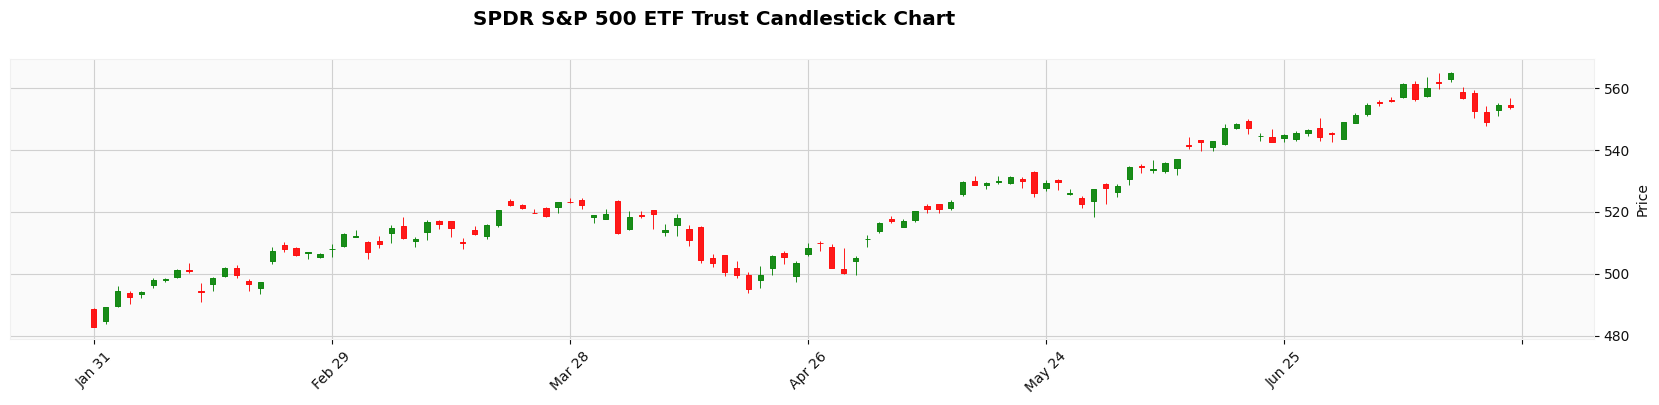

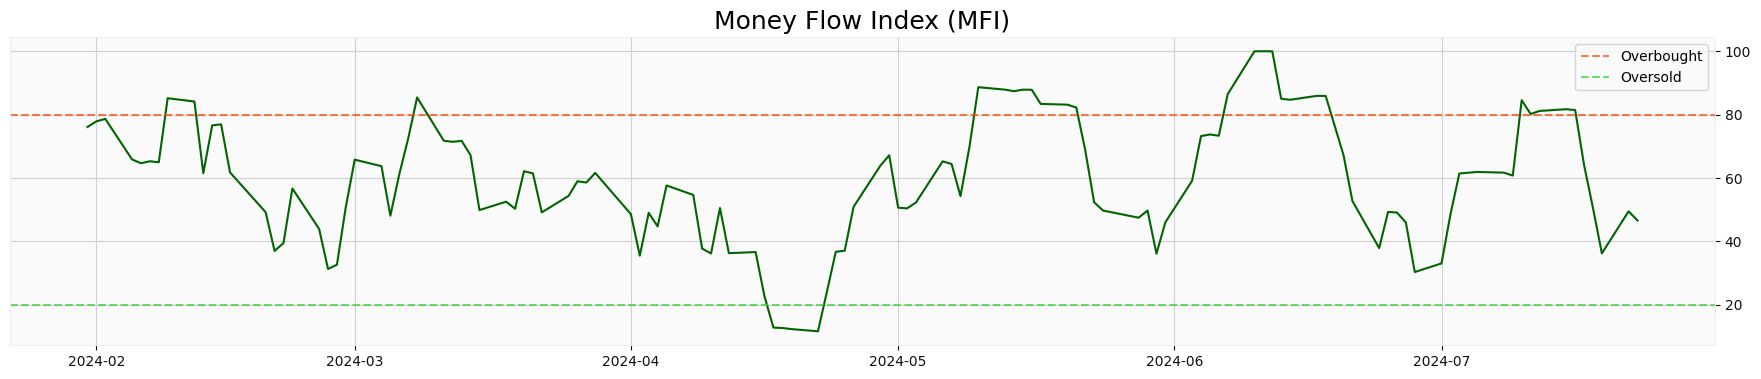

In [ ]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    title= f'{company_name} Candlestick Chart',
    figsize=(22, 4)
)

# Set figure size
plt.figure(figsize=(22, 4))

# Create a new subplot
ax = plt.gca()

# Plot Money Flow Index (MFI)
ax.plot(plot_data.index, plot_data['mfi_7.0'], color='darkgreen')

# Set constant lines
plt.axhline(80, color='orangered', linestyle='--', label='Overbought', alpha=0.7)
plt.axhline(20, color='limegreen', linestyle='--', label='Oversold', alpha=0.7)


# Show Legend
ax.legend(loc='upper right')

# Set title
ax.set_title('Money Flow Index (MFI)', loc='center', fontsize=18)

# Move Y axis ticks to the right
ax.yaxis.tick_right()
# Set label position to the right
ax.yaxis.set_label_position("right")

plt.show();

**Interpreting MFI**
- Above 80: Overbought
- Below 20: Oversold
- Divergence with price: Possible trend reversal
- Crossing 50 level: Potential shift in momentum

Best Used
- Identifying overbought/oversold conditions
- Spotting potential trend reversals
- Confirming price trends


In [ ]:
def add_mfi_signal(df_class, df, n):
  """
  Add MFI signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - n (int): The look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added mfi signal columns.
  """
  # MFI columns
  mfi = f'mfi_{n}'

  # Overbought
  df_class[f'{mfi}_overbought'] = (df[mfi] > 80).astype(int)
  # Oversold
  df_class[f'{mfi}_oversold'] = (df[mfi] < 20).astype(int)
  # Crossovers of 50 level
  df_class[f'{mfi}_50_cross_up'] = ((df[mfi] > 50) & (df[mfi] < 50).shift(1)).astype(int)
  df_class[f'{mfi}_50_cross_down'] = ((df[mfi] < 50) & (df[mfi] > 50).shift(1)).astype(int)


  return df_class

In [ ]:
df_signals = add_mfi_signal(df_signals, df, 7.0)

df_signals.iloc[:, -5:].tail(20)

,ttm_trend_6_bearish,mfi_7.0_overbought,mfi_7.0_oversold,mfi_7.0_50_cross_up,mfi_7.0_50_cross_down
2024-06-25,1,0,0,0,0
2024-06-26,0,0,0,0,0
2024-06-27,0,0,0,0,0
2024-06-28,1,0,0,0,0
2024-07-01,0,0,0,0,0
2024-07-02,0,0,0,0,0
2024-07-03,0,0,0,1,0
2024-07-05,0,0,0,0,0
2024-07-08,0,0,0,0,0
2024-07-09,0,0,0,0,0


### Accumulation/Distribution Oscillator

In [ ]:
help(ta.adosc)

Help on function adosc in module pandas_ta.volume.adosc:

adosc(high, low, close, volume, open_=None, fast=None, slow=None, talib=None, offset=None, **kwargs)
    Accumulation/Distribution Oscillator or Chaikin Oscillator
    
    Accumulation/Distribution Oscillator indicator utilizes
    Accumulation/Distribution and treats it similarily to MACD
    or APO.
    
    Sources:
        https://www.investopedia.com/articles/active-trading/031914/understanding-chaikin-oscillator.asp
    
    Calculation:
        Default Inputs:
            fast=12, slow=26
        AD = Accum/Dist
        ad = AD(high, low, close, open)
        fast_ad = EMA(ad, fast)
        slow_ad = EMA(ad, slow)
        ADOSC = fast_ad - slow_ad
    
    Args:
        high (pd.Series): Series of 'high's
        low (pd.Series): Series of 'low's
        close (pd.Series): Series of 'close's
        open (pd.Series): Series of 'open's
        volume (pd.Series): Series of 'volume's
        fast (int): The short period. D

In [ ]:
def add_adsoc(df, fast, slow):
  """
  Calculate the Accumulation/Distribution Oscillator (A/D) and add it to the DataFrame.
  Parameters:
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added 'ad' column.
  """
  # Calculate the Accumulation/Distribution Oscillator (A/D)
  df[f'adosc_{fast}_{slow}'] = ta.adosc(high=df['high'], low=df['low'], close=df['close'],
                         volume=df['volume'], fast=fast, slow=slow)

  return df

In [ ]:
df = add_adsoc(df, 7, 20)

df.iloc[:, -1:].tail()

,adosc_7_20
2024-07-17,4.333827e+07
2024-07-18,3.074437e+07
2024-07-19,1.487742e+07
2024-07-22,8.507472e+06
2024-07-23,2.083663e+05


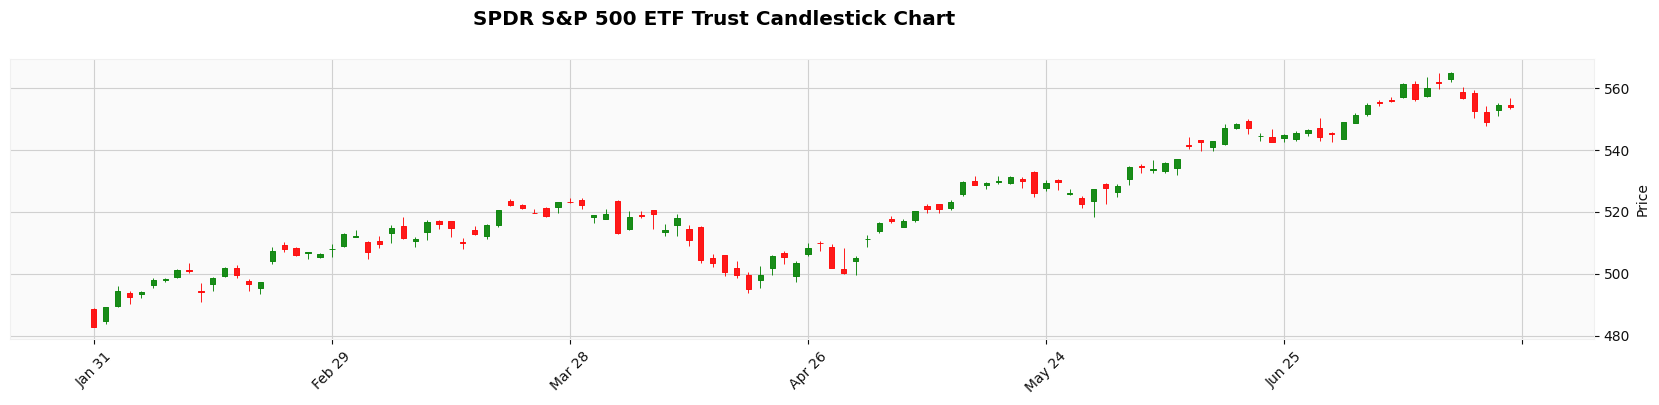

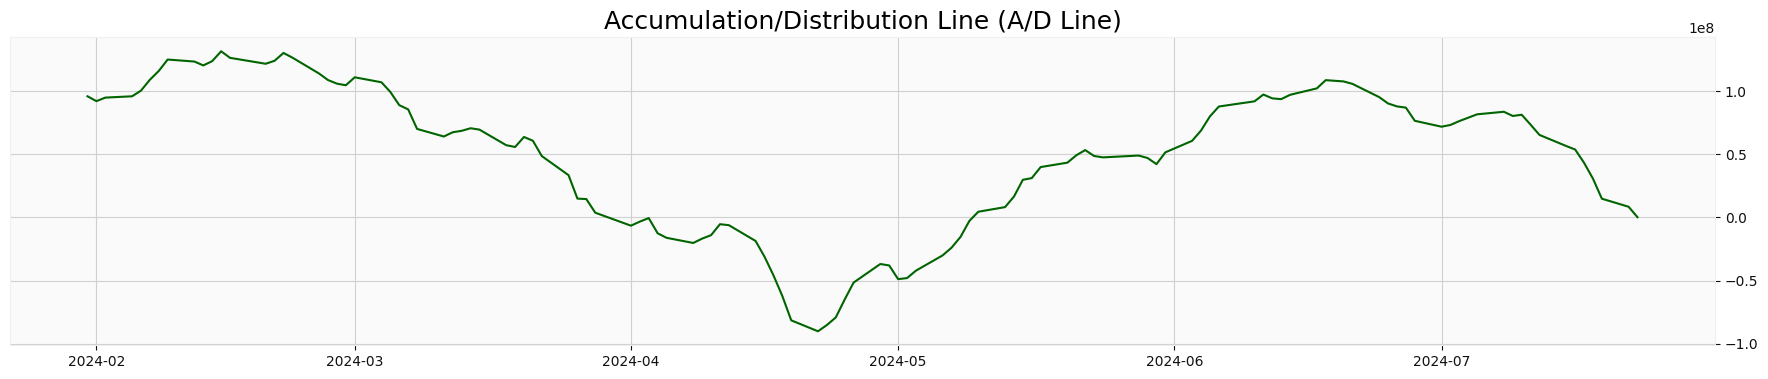

In [ ]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    title= f'{company_name} Candlestick Chart',
    figsize=(22, 4)
)

# Set figure size
plt.figure(figsize=(22, 4))

# Create a new subplot
ax = plt.gca()

# Plot ADX and DMI's
ax.plot(plot_data.index, plot_data['adosc_7_20'], color='darkgreen')

# Set title
ax.set_title('Accumulation/Distribution Line (A/D Line)', loc='center', fontsize=18)

# Move Y axis ticks to the right
ax.yaxis.tick_right()
# Set label position to the right
ax.yaxis.set_label_position("right")

plt.show();

**Key Signals**

- Above zero: Bullish pressure, accumulation
- Below zero: Bearish pressure, distribution
- Crossing zero line: Potential trend change
- Divergence with price: Possible reversal signal


In [ ]:
def add_adosc_signal(df_class, df, fast, slow):
  """
  Add ADOSC signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  - fast (int): The fast look-back period for calculation.
  - slow (int): The slow look-back period for calculation.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added adosc signal columns.
  """
  # ADOSC columns
  adosc = f'adosc_{fast}_{slow}'

  # Bullish
  df_class[f'{adosc}_bullish'] = (df[adosc] > 0).astype(int)
  # Bearish
  df_class[f'{adosc}_bearish'] = (df[adosc] < 0).astype(int)


  return df_class

In [ ]:
df_signals = add_adosc_signal(df_signals, df, 7, 20)

df_signals.iloc[:, -2:].tail()

,adosc_7_20_bullish,adosc_7_20_bearish
2024-07-17,1,0
2024-07-18,1,0
2024-07-19,1,0
2024-07-22,1,0
2024-07-23,1,0


### On Balance Volume (OBV)

In [ ]:
help(ta.obv)

Help on function obv in module pandas_ta.volume.obv:

obv(close, volume, talib=None, offset=None, **kwargs)
    On Balance Volume (OBV)
    
    On Balance Volume is a cumulative indicator to measure buying and selling
    pressure.
    
    Sources:
        https://www.tradingview.com/wiki/On_Balance_Volume_(OBV)
        https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/on-balance-volume-obv/
        https://www.motivewave.com/studies/on_balance_volume.htm
    
    Calculation:
        signed_volume = signed_series(close, initial=1) * volume
        obv = signed_volume.cumsum()
    
    Args:
        close (pd.Series): Series of 'close's
        volume (pd.Series): Series of 'volume's
        talib (bool): If TA Lib is installed and talib is True, Returns the TA Lib
            version. Default: True
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        fillna (value, optional): pd.DataFrame.fillna(value)
      

In [ ]:
def add_obv(df):
  """
  Calculate the On Balance Volume (OBV) and add it to the DataFrame.
  Parameters:
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added 'obv' column.
  """
  # Calculate the On Balance Volume (OBV)
  df['obv'] = ta.obv(close=df['close'], volume=df['volume'])

  return df

In [ ]:
df = add_obv(df)

df.iloc[:, -1:].tail()

,obv
2024-07-17,9.987914e+09
2024-07-18,9.931644e+09
2024-07-19,9.866135e+09
2024-07-22,9.909482e+09
2024-07-23,9.875042e+09


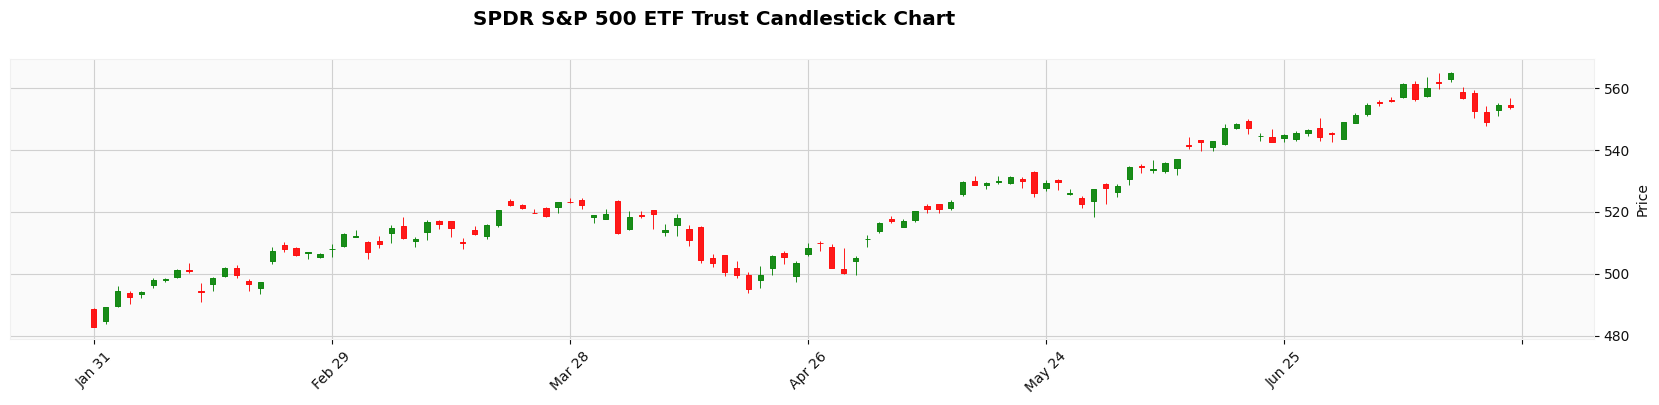

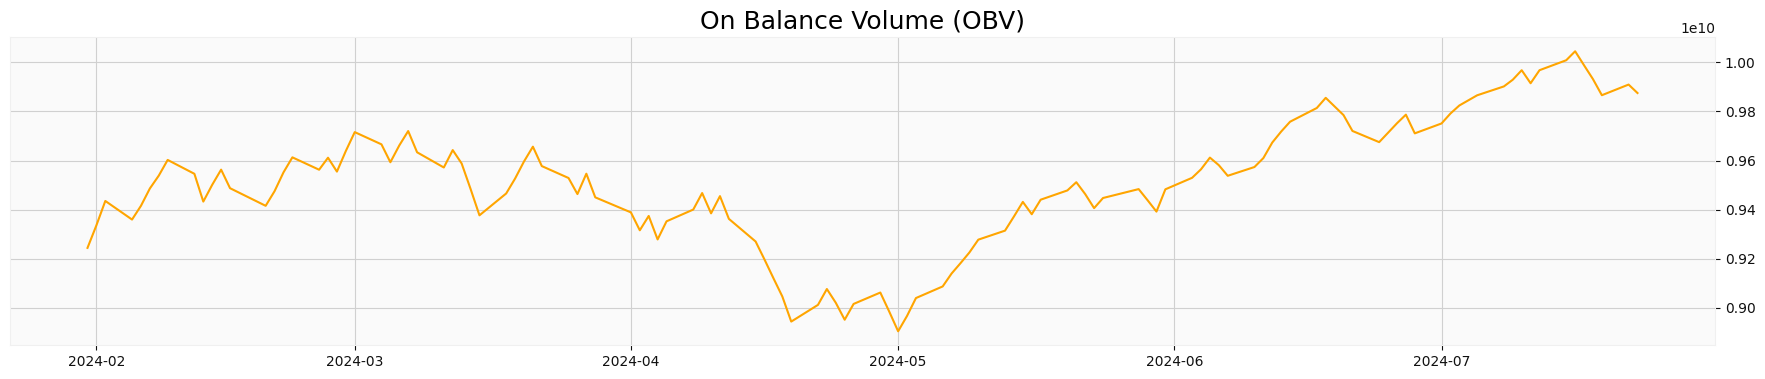

In [ ]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    title= f'{company_name} Candlestick Chart',
    figsize=(22, 4)
)

# Set figure size
plt.figure(figsize=(22, 4))

# Create a new subplot
ax = plt.gca()

# Plot On Balance Volume (OBV)
ax.plot(plot_data.index, plot_data['obv'], color='orange')


# Set title
ax.set_title('On Balance Volume (OBV)', loc='center', fontsize=18)

# Move Y axis ticks to the right
ax.yaxis.tick_right()
# Set label position to the right
ax.yaxis.set_label_position("right")

plt.show();

**Interpreting On Balance Volume (OBV):**
- Rising OBV: Positive volume pressure, bullish
- Falling OBV: Negative volume pressure, bearish


Best Used for
- Confirming price trends
- Spotting potential breakouts
- Identifying divergences

In [ ]:
def add_obv_signal(df_class, df):
  """
  Add OBV signal columns to the DataFrame.
  Parameters:
  - df_class (pandas.DataFrame): DataFrame containing signals of stock data.
  - df (pandas.DataFrame): DataFrame containing intraday stock data.
  Returns:
  - df (pandas.DataFrame): The same DataFrame with added obv signal columns.
  """
  # OBV columns
  obv = 'obv'
  # Bullish
  df_class[f'{obv}_bullish'] = (df[obv] > df[obv].shift(1)).astype(int)
  # Bearish
  df_class[f'{obv}_bearish'] = (df[obv] < df[obv].shift(1)).astype(int)

  return df_class


In [ ]:
df_signals = add_obv_signal(df_signals, df)

df_signals.iloc[:, -2:].tail()

,obv_bullish,obv_bearish
2024-07-17,0,1
2024-07-18,0,1
2024-07-19,0,1
2024-07-22,1,0
2024-07-23,0,1


# Pre-Processing and Feature Selection

## Defining Functions

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def preprocess_df(df, target):
    """
    Preprocess the DataFrame by isolating the target variable and scaling the features.

    Parameters:
        df (DataFrame): Input DataFrame.
        target (str): Name of the target variable column.

    Returns:
        DataFrame: Scaled features DataFrame.
        Series: Target variable Series.
    """
    # Define the scaler
    scaler = MinMaxScaler()

    # Extract features and target variable
    X = df.drop(columns=target)
    y = df[target]

    # Scale the features
    X_scaled = scaler.fit_transform(X)

    # Convert the scaled features back to DataFrame
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    return X_scaled, y

In [ ]:
def get_signals(df):
    # Create Signals DataFrame
    df_signals = df[['close']].copy()
    df_signals = add_future_trend(df, 10)

    df_signals = add_roc_signals(df_signals, df, 1)
    df_signals = add_rsi_signals(df_signals, df, 7)
    df_signals = add_macd_signals(df_signals, df, 5, 20, 9)
    df_signals = add_stoch_signals(df_signals, df, 5, 3, 3)
    df_signals = add_cci_signals(df_signals, df, 7)
    df_signals = add_cmo_signals(df_signals, df, 7)
    df_signals = add_willr_signals(df_signals, df, 7)
    df_signals = add_ema_signals(df_signals, df, 10)
    df_signals = add_tema_signals(df_signals, df, fast=5, mid=20, slow=50)
    df_signals = add_mcgd_signals(df_signals, df, 10)
    df_signals = add_supertrend_signals(df_signals, df, 7, 1.5)
    df_signals = add_atr_signals(df_signals, df, 5, 0.5)
    df_signals = add_bbands_signal(df_signals, df, 10, 1.5)
    df_signals = add_adx_signals(df_signals, df, 7)
    df_signals = add_ttm_trend_signal(df_signals, df, 6)
    df_signals = add_mfi_signal(df_signals, df, 7)
    df_signals = add_adosc_signal(df_signals, df, 7, 20)
    df_signals = add_obv_signal(df_signals, df)

    return df


In [ ]:
def plot_correlation_heatmap(df, figsize=(22, 8), title='Correlation Heatmap'):
    """
    Plot a correlation heatmap for a given DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame with the data to plot
    figsize (tuple): Size of the figure (default: (22, 8))
    title (str): Title of the plot (default: 'Correlation Heatmap')

    Returns:
    None
    """
    # Set figure size
    plt.figure(figsize=figsize)
    sns.set_style("white")

    # Plot Correlation heatmap
    sns.heatmap(df.corr(),
                vmin=-1,
                vmax=1,
                annot=True,
                cmap=sns.color_palette("vlag", as_cmap=True)
                )

    # Set plot title and labels
    plt.title(title, fontsize=14)

    # Show plot
    plt.show()

In [ ]:
def get_data(df, ticker):

    # Fetch 'ticker' Data from Alpha Vantage API
    df = av_daily(ticker, 'full') #SPY
    df = clean_data(df)


    # Add future close and trend (Target)
    #df = add_future_close(df, 10)
    df = add_future_trend(df, 14)

    # Add technical indicators
    # df = add_intraday_variations(df)
    # Momentum
    df = add_roc(df, 20)
    # df = add_rsi(df, 18)
    # df = add_macd(df, 12, 26, 9)
    # df = add_stoch_ta(df, k=14, d=3, smooth_k=3)
    # df = add_cci(df, 20)
    # df = add_cmo(df, n=20)
    # df = add_willr(df, 14)

    # Overlap
    #df = add_ema(df, n=20)
    df = add_tema(df, fast=10, mid=20, slow=50)
    # df = add_mcgd(df)
    # df = add_supertrend(df, n=10, multiplier=3.0)

    # Volatility
    df = add_atr(df, n=14)
    df = add_bbands(df, n=20, std=2.0)
    # Trend
    df = add_adx(df, n=14)
    # df = add_ttm_trend(df)
    # Volume
    # df = add_mfi(df, n=7)
    df = add_adsoc(df, fast=3, slow=10)
    df = add_obv(df)

    df.dropna(inplace=True)
    df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
    df.drop(columns=['BBU_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0'], inplace=True)


    return df



## Feature Selection

In [ ]:
df = get_data(df, 'SPY')

df.tail()

Index(['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0'], dtype='object')


,close,future_trend_14,roc_20,tema_10,tema_20,tema_50,atr_14,BBB_20_2.0,BBP_20_2.0,ADX_14,DMP_14,DMN_14,adosc_3_10,obv
2024-07-31,550.81,0,0.327863,543.998206,545.505400,554.302863,6.646487,5.145583,0.440467,32.928667,18.250768,25.815185,-4.912627e+07,9.851458e+09
2024-08-01,543.01,0,-1.532296,542.924464,544.251842,553.418840,7.274509,5.362874,0.193657,32.845947,15.484063,29.904165,-5.396523e+07,9.775029e+09
2024-08-02,532.90,0,-3.919660,537.738917,540.634053,551.442460,7.784187,6.145927,-0.034290,33.751039,13.436639,35.887733,-5.037955e+07,9.692240e+09
2024-08-05,517.38,0,-6.825385,527.396140,533.689935,547.847762,8.844602,8.100523,-0.213088,35.636761,10.980976,44.132153,-4.115082e+07,9.545973e+09
2024-08-06,522.03,0,-6.079306,522.840014,529.281038,545.043451,9.095702,9.102427,-0.009328,36.374304,14.752578,39.848549,-4.175097e+07,9.630646e+09


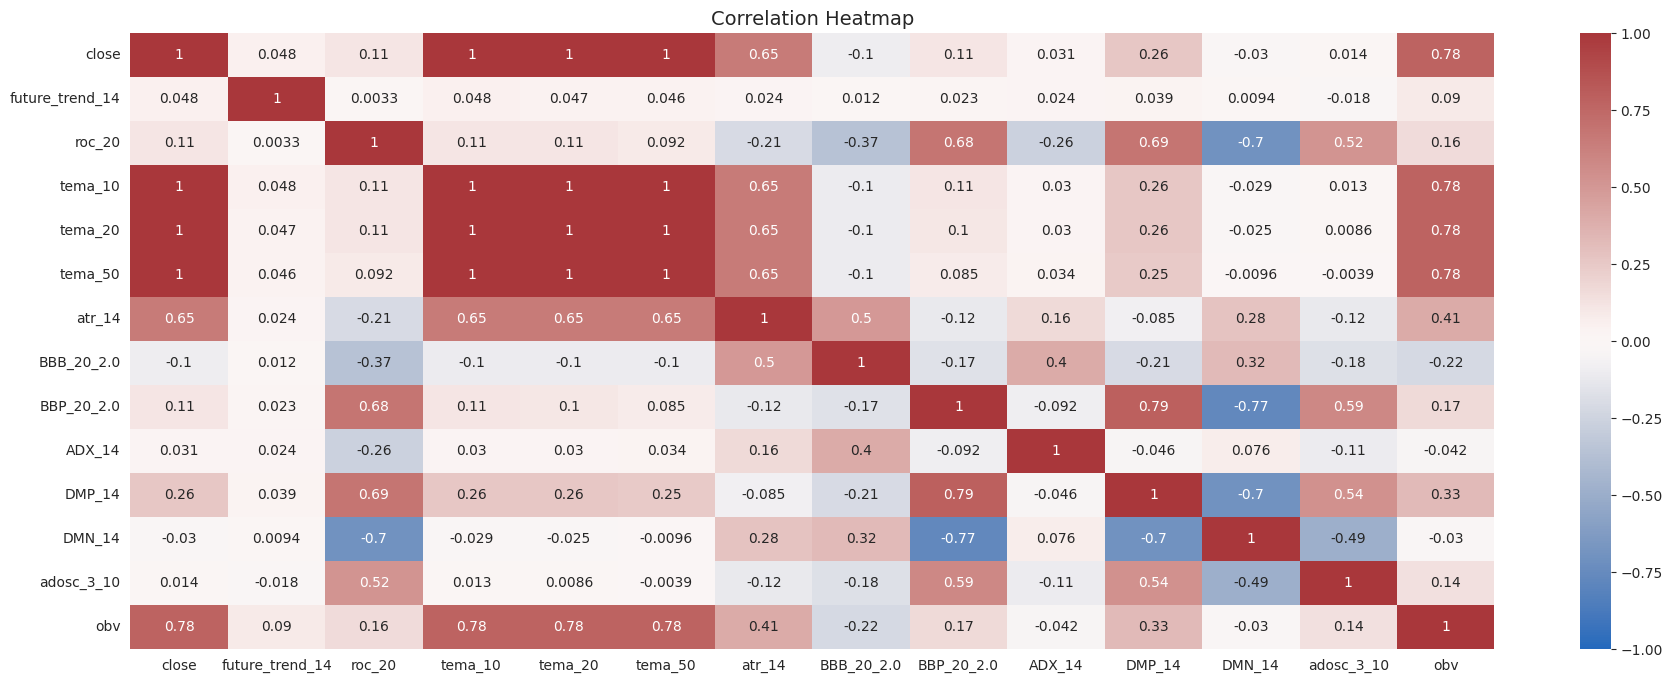

In [ ]:
plot_correlation_heatmap(df)

In [ ]:
df_ml = df.copy()
df_ml = df_ml[df_ml.index <= '2024-06-01']


In [ ]:
# Preprocess the DataFrame
X, y = preprocess_df(df_ml, 'future_trend_14')


X.head(), y.head()

(               close    roc_20   tema_10   tema_20   tema_50    atr_14  \
 2000-01-11  0.164900  0.607043  0.164005  0.163823  0.153035  0.131230   
 2000-01-12  0.161797  0.606528  0.163175  0.163284  0.153411  0.125656   
 2000-01-13  0.165979  0.621777  0.164504  0.163914  0.154240  0.125411   
 2000-01-14  0.170229  0.638937  0.167304  0.165520  0.155495  0.124076   
 2000-01-18  0.167733  0.616574  0.168016  0.166173  0.156364  0.119367   
 
             BBB_20_2.0  BBP_20_2.0    ADX_14    DMP_14    DMN_14  adosc_3_10  \
 2000-01-11    0.156106    0.588880  0.190577  0.373746  0.333696    0.628468   
 2000-01-12    0.150580    0.507094  0.179063  0.351463  0.342257    0.626876   
 2000-01-13    0.147226    0.602168  0.156615  0.387526  0.312893    0.626842   
 2000-01-14    0.149124    0.694255  0.142985  0.457992  0.287725    0.627573   
 2000-01-18    0.148427    0.623977  0.122719  0.430093  0.305034    0.627642   
 
                  obv  
 2000-01-11  0.142246  
 2000-01-12 

# Building the Model

## XG boost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Train the model
num_round = 100
model = xgb.train(params, dtrain, num_round)

# Make predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if y > 0.5 else 0 for y in y_pred]

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

# Create classification report
class_report = classification_report(y_test, y_pred_binary, output_dict=True)

# Convert report to df
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df

Accuracy: 0.8550


,precision,recall,f1-score,support
0,0.863736,0.772102,0.815353,509.000000
1,0.849935,0.913769,0.880697,719.000000
accuracy,0.855049,0.855049,0.855049,0.855049
macro avg,0.856836,0.842936,0.848025,1228.000000
weighted avg,0.855656,0.855049,0.853612,1228.000000


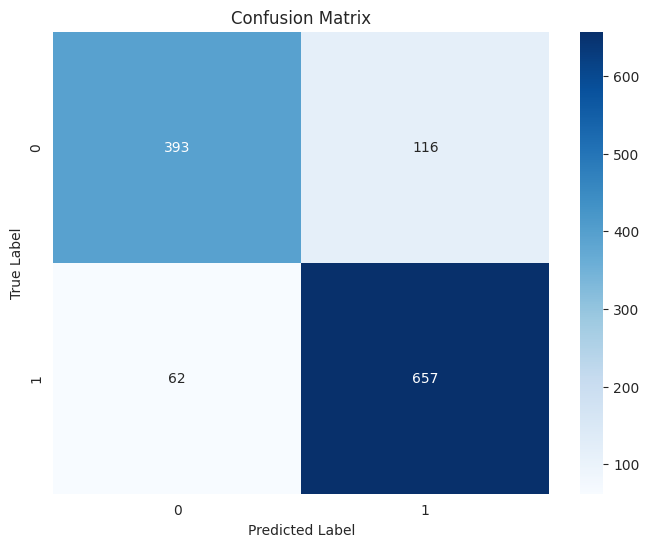

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show();

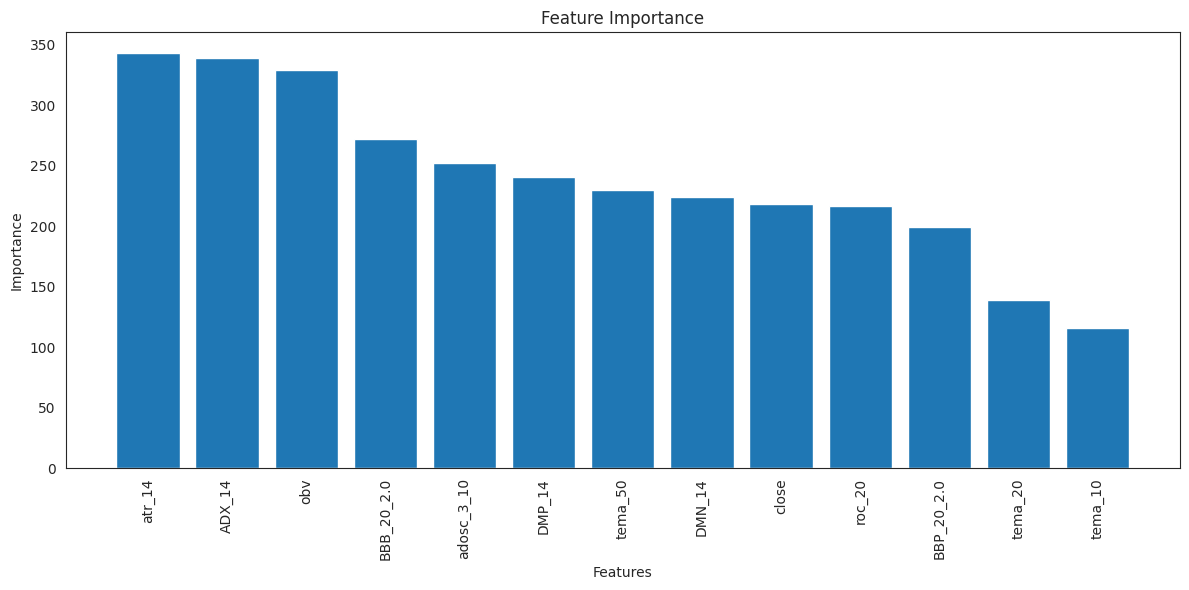

In [ ]:
# Feature importance
importance = model.get_score(importance_type='weight')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
feature_names, feature_importance = zip(*importance)

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xticks(range(len(feature_importance)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
from joblib import dump

# Save the trained model to a file
model_file = '/content/drive/MyDrive/Colab Notebooks/algorithmic_trading/xgb_model.joblib'
dump(model, model_file)

print(f"Model saved to {model_file}")

Model saved to /content/drive/MyDrive/Colab Notebooks/algorithmic_trading/xgb_model.joblib


In [ ]:
from joblib import load

# Load the model from the file
model_loaded = load(model_file)

In [ ]:
# Assuming df_new is your new DataFrame with unseen data
df_val = df.copy()  # Fetch the data for the same ticker, e.g., SPY
df_val = df_val[df_val.index > '2024-06-01']

# Preprocess the new DataFrame
X_val, y_val = preprocess_df(df_val, 'future_trend_14')

# Convert the preprocessed data into DMatrix
dnew = xgb.DMatrix(X_val)


In [ ]:
# Make predictions on new data using the loaded model
y_val_pred = model_loaded.predict(dnew)

# Convert probabilities to binary predictions
y_val_pred_binary = [1 if y > 0.5 else 0 for y in y_val_pred]



# # Add the predictions to the DataFrame (optional)
# df_new['Predicted_Trend'] = y_new_pred_binary

# # Output the prediction results
# print(df_new[['Predicted_Trend']])


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

# Create classification report
class_report = classification_report(y_val, y_val_pred_binary, output_dict=True)

# Convert report to df
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df

Accuracy: 0.4000


,precision,recall,f1-score,support
0,0.454545,0.625000,0.526316,24.0
1,0.250000,0.142857,0.181818,21.0
accuracy,0.400000,0.400000,0.400000,0.4
macro avg,0.352273,0.383929,0.354067,45.0
weighted avg,0.359091,0.400000,0.365550,45.0


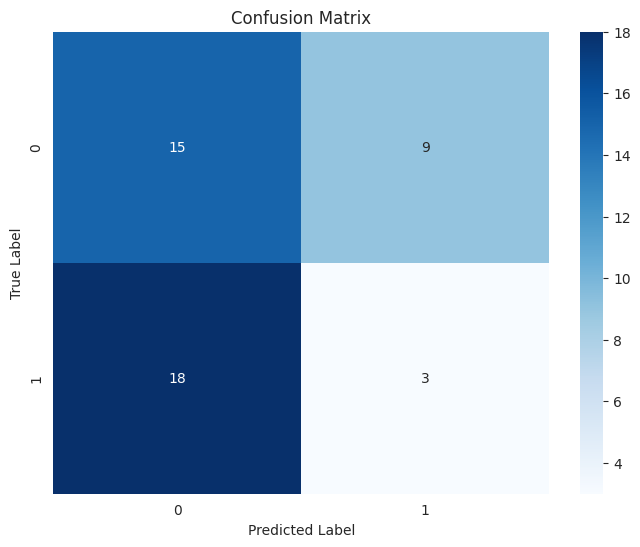

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_val, y_val_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show();

# Generate the final DataFrame

In [ ]:
# def generate_stock_data(original_df, model, X_seq, y_actual):
#     """
#     Create the final dataset with original features, actual price trend,
#     forecasted trend, and forecast accuracy.

#     Parameters:
#         original_df (DataFrame): Original DataFrame before scaling and dropping columns.
#         model (keras.Model): Trained LSTM model.
#         X_seq (np.array): Array of input sequences.
#         y_actual (np.array): Array of actual price trend labels.

#     Returns:
#         DataFrame: Final dataset with original features, actual and forecasted trends, and forecast accuracy.
#     """
#     # Make predictions using the LSTM model
#     y_pred = model.predict(X_seq)

#     # Convert predictions to binary format (0 or 1)
#     y_pred_binary = (y_pred > 0.5).astype(int).flatten()

#     # Drop rows with missing values from the original DataFrame
#     original_df.dropna(inplace=True)

#     # Initialize the final dataframe with indices aligned to y_actual using negative indexing
#     final_df = original_df.iloc[-len(y_actual):].copy()

#     # Calculate 'trend' based on the change in 'close' prices
#     final_df['trend'] = (df['close'].shift(1) < df['close']).astype(int)

#     # Add columns for actual and forecasted target
#     final_df['actual_target'] = y_actual
#     final_df['forecast_target'] = y_pred_binary

#     # Calculate accuracy by comparing actual and forecasted trends
#     final_df['accuracy'] = (final_df['actual_target'] == final_df['forecast_target']).astype(int)

#     return final_df
